In [1]:
# ============================================================================
# CNN-LSTM Bestandsforecast-Modell
# Projekt: Vorhersage von Bestellmengen für Retail-Inventory
# ============================================================================
# Standard Libraries
from typing import Tuple, List, Dict, Any, Optional
from dataclasses import dataclass, field
import warnings
warnings.filterwarnings('ignore')

# Data Science
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

## Konfiguration & Utility-Funktionen

In [2]:
# ============================================================================
# KONFIGURATION (mit @dataclass für Immutability & Type-Safety)
# ============================================================================

@dataclass(frozen=True)
class Config:
    """
    Immutable Konfiguration für das Projekt.
    
    frozen=True: Macht Instanzen unveränderlich (verhindert Bugs)
    """
    # Datenpfade
    data_path: str = "/Users/mag/Library/Mobile Documents/com~apple~CloudDocs/Studium/7. Semester/Machine und Deep Learning/Bestands_Forecast/retail_store_inventory.csv"
    
    # Zeitreihen-Parameter
    seq_length: int = 30
    target_col: str = "Inventory Level"
    
    # Train/Test Split
    test_size: float = 0.2
    random_state: int = 42
    
    # Modell-Architektur (VEREINFACHT!)
    conv_filters: Tuple[int, int] = (64, 32)
    lstm_units: Tuple[int,] = (64,)  # NUR 1 LSTM Layer!
    dense_units: Tuple[int, int] = (32, 16)
    
    # Training
    batch_size: int = 64
    epochs: int = 50
    learning_rate: float = 0.001
    weight_decay: float = 0.0  # DEAKTIVIERT (verwenden L2 stattdessen)
    
    # Regularisierung (REDUZIERT!)
    dropout_rate: float = 0.1  # War 0.2, jetzt 0.1
    l2_reg: float = 0.0001  # War 0.001, jetzt 0.0001
    early_stopping_patience: int = 10  # War 5, jetzt 10
    lr_reduce_patience: int = 5  # War 3, jetzt 5
    lr_reduce_factor: float = 0.5
    
    # Feature Engineering
    groupby_cols: Tuple[str, str] = ("Store_ID_Encoded", "Product_ID_Encoded")
    id_cols: Tuple[str, ...] = ("Store_ID_Encoded", "Product_ID_Encoded")
    exclude_from_scaling: Tuple[str, ...] = field(default_factory=lambda: ("Date",))


@dataclass
class ProcessedData:
    """Container für vorverarbeitete Daten (verhindert lose Variablen)."""
    X_train: np.ndarray
    y_train: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    feature_cols: List[str]
    scaler_features: StandardScaler
    scaler_target: StandardScaler
    mappings: Dict[str, Dict]


@dataclass
class TrainingResults:
    """Container für Training-Ergebnisse."""
    model: tf.keras.Model
    history: tf.keras.callbacks.History
    test_metrics: Dict[str, float]
    predictions: np.ndarray


# Instanziieren
config = Config()
print("✓ Konfiguration geladen (immutable dataclass)")
print("⚠️  Regularisierung REDUZIERT für besseres Lernen:")

✓ Konfiguration geladen (immutable dataclass)
⚠️  Regularisierung REDUZIERT für besseres Lernen:


In [3]:
# ============================================================================
# DATEN-LOADING & EXPLORATION
# ============================================================================

def load_and_explore_data(file_path: str) -> pd.DataFrame:
    """
    Lädt CSV-Datei und führt grundlegende Exploration durch.
    
    Args:
        file_path: Pfad zur CSV-Datei
        
    Returns:
        DataFrame mit geladenen Daten
    """
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    print("=" * 70)
    print("📊 DATEN-ÜBERSICHT")
    print("=" * 70)
    print(f"Shape: {df.shape} (Zeilen, Spalten)")
    print(f"Date Range: {df['Date'].min()} bis {df['Date'].max()}")
    print(f"Total Tage: {(df['Date'].max() - df['Date'].min()).days + 1}")
    
    print("\n" + "=" * 70)
    print("📋 DATENTYPEN & FEHLENDE WERTE")
    print("=" * 70)
    print(df.info())
    print(f"\nFehlende Werte: {df.isnull().sum().sum()} (Gesamt)")
    
    print("\n" + "=" * 70)
    print("📈 STATISTISCHE ZUSAMMENFASSUNG")
    print("=" * 70)
    print(df.describe().round(2))
    
    return df

In [4]:
# Laden und explorieren
df = load_and_explore_data(config.data_path)

📊 DATEN-ÜBERSICHT
Shape: (73100, 15) (Zeilen, Spalten)
Date Range: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
Total Tage: 731

📋 DATENTYPEN & FEHLENDE WERTE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  

## Feature Engineering: Encoding, Split, Skalierung

In [5]:
# ============================================================================
# SEQUENZEN-ERSTELLUNG
# ============================================================================

def create_sequences_from_group(
    group: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    seq_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Erstellt Sequenzen aus einer einzigen Store-Product-Gruppe.
    
    Logik:
    - Input: seq_length aufeinanderfolgende Tage (Features)
    - Output: Nächster Tag (Target)
    
    Args:
        group: DataFrame für eine Store-Product-Kombination
        feature_cols: Feature-Spalten
        target_col: Zielgröße
        seq_length: Länge der Sequenzen (z.B. 30 Tage)
        
    Returns:
        Tupel (X, y) mit shapes ((n_samples, seq_length, n_features), (n_samples,))
    """
    data_features = group[feature_cols].values
    data_target = group[target_col].values
    
    X_list, y_list = [], []
    
    # Sliding Window über die Gruppe
    for i in range(len(group) - seq_length):
        x_seq = data_features[i:i + seq_length]
        y_t = data_target[i + seq_length]
        X_list.append(x_seq)
        y_list.append(y_t)
    
    if not X_list:
        return np.empty((0, seq_length, len(feature_cols))), np.empty((0,))
    
    return np.array(X_list), np.array(y_list)


def create_sequences_dataset(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    seq_length: int,
    groupby_cols: List[str] = ["Store_ID_Encoded", "Product_ID_Encoded"]
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Erstellt Sequenzen für ALLE Store-Product-Gruppen.
    
    Grund der Gruppierung: Verhindert Leakage über Stores/Produkte hinweg.
    
    Args:
        df: Skalierter DataFrame
        feature_cols: Feature-Spalten
        target_col: Zielgröße
        seq_length: Sequenzlänge (z.B. 30 Tage)
        groupby_cols: Spalten zum Gruppieren (Default: Store + Product)
        
    Returns:
        Tupel (X, y) mit shapes ((total_samples, seq_length, n_features), (total_samples,))
    """
    X_all, y_all = [], []
    
    grouped = df.groupby(groupby_cols)
    n_groups = len(grouped)
    
    for (store_id, prod_id), group in grouped:
        X_group, y_group = create_sequences_from_group(group, feature_cols, target_col, seq_length)
        if len(X_group) > 0:
            X_all.append(X_group)
            y_all.append(y_group)
    
    if not X_all:
        raise ValueError(f"❌ Keine Sequenzen erzeugt! SEQ_LENGTH={seq_length} möglicherweise zu groß.")
    
    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)
    
    print(f"✓ Sequenzen erstellt aus {n_groups} Store-Product-Gruppen")
    print(f"  X shape: {X.shape} (Samples, TimeSteps, Features)")
    print(f"  y shape: {y.shape}")
    
    return X, y

In [6]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

def encode_categorical_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, Dict]]:
    """
    Konvertiert kategorische Variablen zu numerischen Features.
    
    Strategie:
    - Store ID & Product ID: Label-Encoding (für zukünftige Embeddings)
    - Kategorien: One-Hot-Encoding (semantische Bedeutung)
    
    Args:
        df: Input DataFrame
        
    Returns:
        Tupel (encoded_df, mapping_dict)
    """
    df = df.copy()
    mappings = {}
    
    # Label-Encoding für Store und Product
    for col in ["Store ID", "Product ID"]:
        unique_vals = df[col].unique()
        mapping = {val: idx for idx, val in enumerate(unique_vals)}
        encoded_col_name = col.replace(" ", "_") + "_Encoded"
        df[encoded_col_name] = df[col].map(mapping)
        mappings[col] = mapping
    
    # One-Hot für kategorische Features
    cat_cols = ["Category", "Region", "Weather Condition", "Seasonality"]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=False)
    
    # Aufräumen: alte Spalten entfernen, Date behalten
    df = df.drop(columns=["Store ID", "Product ID"], errors='ignore')
    
    print("✓ Encoding abgeschlossen!")
    print(f"  Features nach Encoding: {df.shape[1]} Spalten")
    
    return df, mappings


def train_test_time_split(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Zeitbasierter Train/Test Split (verhindert Data Leakage).
    
    Strategie: Die letzten X% sind Test (Zukunft), erste (1-X)% sind Train (Vergangenheit).
    
    Args:
        df: Input DataFrame (muss 'Date' Spalte haben)
        test_size: Anteil für Test (z.B. 0.2 = 20%)
        
    Returns:
        Tupel (df_train, df_test)
    """
    df = df.sort_values("Date").reset_index(drop=True)
    n_test = int(len(df) * test_size)
    
    df_train = df.iloc[:-n_test].copy()
    df_test = df.iloc[-n_test:].copy()
    
    print("✓ Train/Test Split (zeitbasiert) durchgeführt!")
    print(f"  Train: {len(df_train)} Zeilen ({100*(1-test_size):.0f}%)")
    print(f"  Test:  {len(df_test)} Zeilen ({100*test_size:.0f}%)")
    
    return df_train, df_test


def scale_data(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    feature_cols: List[str],
    target_col: str
) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler, StandardScaler]:
    """
    Standardisiert Features und Target mit StandardScaler.
    
    Wichtig: Scaler wird auf Training-Daten angepasst, dann auf Test angewendet!
    
    Args:
        df_train: Trainings-DataFrame
        df_test: Test-DataFrame
        feature_cols: Liste der Feature-Spalten
        target_col: Name der Zielgröße
        
    Returns:
        Tupel (df_train_scaled, df_test_scaled, scaler_features, scaler_target)
    """
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    
    # Features: fit auf Train, transform auf beide
    df_train_scaled[feature_cols] = scaler_features.fit_transform(df_train[feature_cols])
    df_test_scaled[feature_cols] = scaler_features.transform(df_test[feature_cols])
    
    # Target: fit auf Train, transform auf beide
    df_train_scaled[[target_col]] = scaler_target.fit_transform(df_train[[target_col]])
    df_test_scaled[[target_col]] = scaler_target.transform(df_test[[target_col]])
    
    print("✓ Skalierung (StandardScaler) durchgeführt!")
    print(f"  {len(feature_cols)} Features + 1 Target skaliert")
    
    return df_train_scaled, df_test_scaled, scaler_features, scaler_target

In [7]:
# ============================================================================
# FEATURE ENGINEERING DURCHFÜHREN
# ============================================================================

def prepare_data_pipeline(df: pd.DataFrame, config: Config) -> ProcessedData:
    """
    Komplette Data-Preparation-Pipeline (Single Responsibility).
    
    Führt alle Schritte aus:
    1. Encoding kategorischer Features
    2. Train/Test Split (zeitbasiert)
    3. Feature-Identifikation
    4. Skalierung
    5. Sequenzen-Erstellung
    
    Args:
        df: Rohdaten DataFrame
        config: Konfiguration
        
    Returns:
        ProcessedData Container mit allen vorverarbeiteten Daten
    """
    # 1. Encoding
    df_encoded, mappings = encode_categorical_features(df)
    
    # 2. Split
    df_train, df_test = train_test_time_split(df_encoded, test_size=config.test_size)
    
    # 3. Feature-Identifikation
    exclude_cols = [config.target_col, *config.exclude_from_scaling, *config.id_cols]
    feature_cols = [col for col in df_train.columns if col not in exclude_cols]
    print(f"✓ {len(feature_cols)} Features identifiziert (ohne IDs)")
    
    # 4. Skalierung
    df_train_scaled, df_test_scaled, scaler_feat, scaler_tgt = scale_data(
        df_train, df_test, feature_cols, config.target_col
    )
    
    # 5. Sequenzen
    print("\n🔄 Erstelle Sequenzen...")
    X_train, y_train = create_sequences_dataset(
        df_train_scaled, feature_cols, config.target_col, 
        config.seq_length, list(config.groupby_cols)
    )
    X_test, y_test = create_sequences_dataset(
        df_test_scaled, feature_cols, config.target_col, 
        config.seq_length, list(config.groupby_cols)
    )
    
    return ProcessedData(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        feature_cols=feature_cols,
        scaler_features=scaler_feat,
        scaler_target=scaler_tgt,
        mappings=mappings
    )


# Pipeline ausführen
print("🔄 Starte Data Preparation Pipeline...\n")
data = prepare_data_pipeline(df, config)
print(f"\n✅ Pipeline abgeschlossen!")
print(f"   Train: {data.X_train.shape}, Test: {data.X_test.shape}")

🔄 Starte Data Preparation Pipeline...

✓ Encoding abgeschlossen!
  Features nach Encoding: 28 Spalten
✓ Train/Test Split (zeitbasiert) durchgeführt!
  Train: 58480 Zeilen (80%)
  Test:  14620 Zeilen (20%)
✓ 24 Features identifiziert (ohne IDs)
✓ Skalierung (StandardScaler) durchgeführt!
  24 Features + 1 Target skaliert

🔄 Erstelle Sequenzen...
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (55480, 30, 24) (Samples, TimeSteps, Features)
  y shape: (55480,)
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (11620, 30, 24) (Samples, TimeSteps, Features)
  y shape: (11620,)

✅ Pipeline abgeschlossen!
   Train: (55480, 30, 24), Test: (11620, 30, 24)


## Modellaufbau

In [8]:
# ============================================================================
# MODELLAUFBAU (Best-Practice Architektur)
# ============================================================================

def build_cnn_lstm_model(
    seq_length: int,
    num_features: int,
    config: Config
) -> tf.keras.Model:
    """
    Baut CNN-BiLSTM Architektur mit Best-Practice Patterns.
    
    VERBESSERUNGEN:
    ✓ Bidirektionale LSTMs 
    ✓ Layer Normalization
    ✓ L2 Regularisierung
    ✓ AdamW Optimizer
    
    Args:
        seq_length: Zeitschritte (z.B. 30)
        num_features: Features pro Zeitschritt (z.B. 24)
        config: Konfigurationsobjekt
        
    Returns:
        Kompiliertes TensorFlow Modell
    """
    inputs = layers.Input(shape=(seq_length, num_features), name="time_series_input")
    
    # CNN-Block
    x = inputs
    for i, filters in enumerate(config.conv_filters, 1):
        x = layers.Conv1D(
            filters=filters, 
            kernel_size=3, 
            padding="same", 
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
            name=f"conv1d_{i}"
        )(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        if i == len(config.conv_filters):
            x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(config.dropout_rate)(x)
    
    # BiLSTM-Block (KEIN internes Dropout mehr!)
    for i, units in enumerate(config.lstm_units, 1):
        return_seq = (i < len(config.lstm_units))
        x = layers.Bidirectional(
            layers.LSTM(units, return_sequences=return_seq),  # KEIN dropout= Parameter!
            name=f"bilstm_{i}"
        )(x)
        if not return_seq:
            x = layers.Dropout(config.dropout_rate)(x)  # NUR externes Dropout
    
    # Dense-Block
    for i, units in enumerate(config.dense_units, 1):
        x = layers.Dense(units, activation="relu", 
                        kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg))(x)
        if i < len(config.dense_units):
            x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Dropout(config.dropout_rate * (0.75 if i == len(config.dense_units) else 1))(x)
    
    # Output
    outputs = layers.Dense(1, name="units_sold_prediction")(x)
    
    # Kompilieren
    model = models.Model(inputs=inputs, outputs=outputs, name="CNN_BiLSTM_Forecast")
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay
        ),
        loss="mse",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name="mae"),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mape"),
            tf.keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )
    
    return model


# Modell bauen
print("\n🏗️  Baue CNN-BiLSTM Modell...\n")
num_features = data.X_train.shape[2]
model = build_cnn_lstm_model(config.seq_length, num_features, config)

print("\n✓ Modell-Architektur:")
model.summary()



🏗️  Baue CNN-BiLSTM Modell...


✓ Modell-Architektur:


Model: "CNN_BiLSTM_Forecast"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_series_input (InputLayer)  │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 30, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 30, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ units_sold_prediction (Dense)   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,441 (255.63 KB)

 Trainable params: 65,441 (255.63 KB)

 Non-trainable params: 0 (0.00 B)

## Training & Evaluation


🔬 STARTE FEATURE IMPORTANCE ANALYSEN...

1️⃣  KORRELATIONSANALYSE
📊 TOP 15 FEATURES MIT HÖCHSTER KORRELATION ZU 'Inventory Level'
 1. Units Sold                               + 0.5900 █████████████████████████████
 2. Demand Forecast                          + 0.5886 █████████████████████████████
 3. Competitor Pricing                       + 0.0094 
 4. Price                                    + 0.0091 
 5. Discount                                 + 0.0049 
 6. Holiday/Promotion                        + 0.0034 
 7. Units Ordered                            + 0.0011 


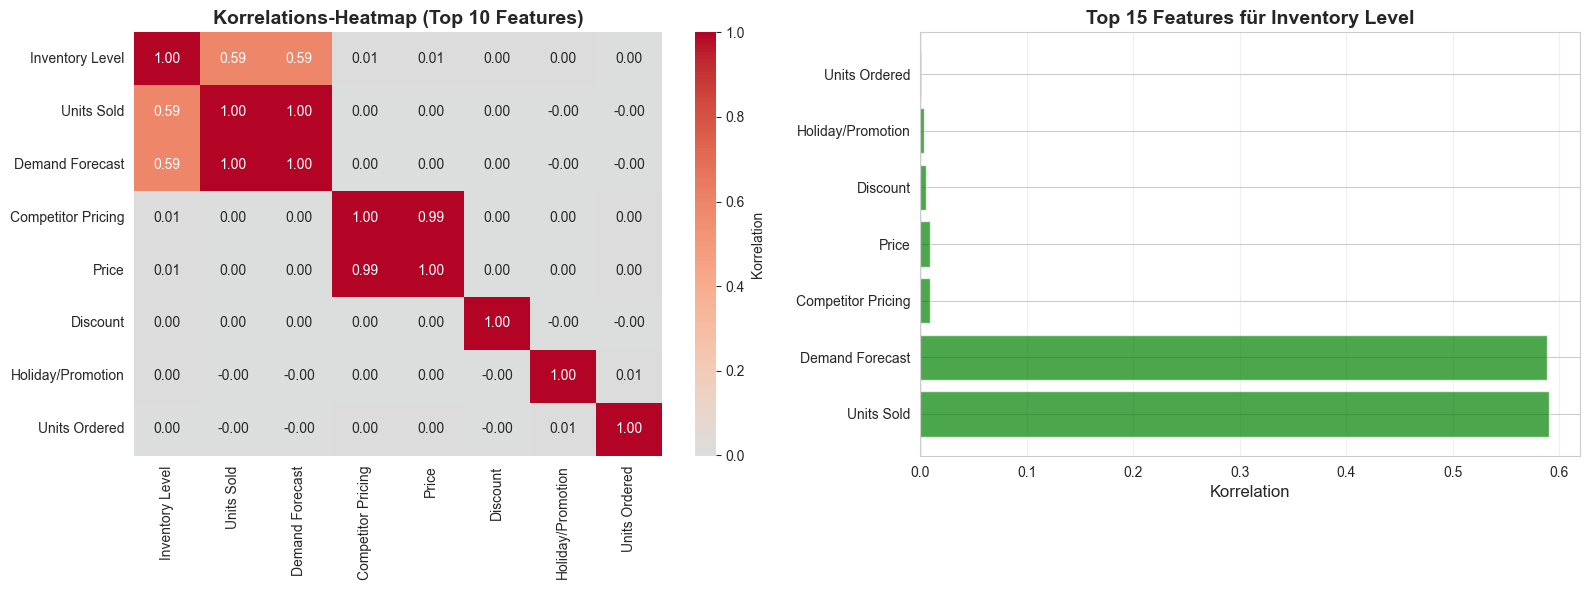


2️⃣  FEATURE VERTEILUNGEN & BEZIEHUNGEN


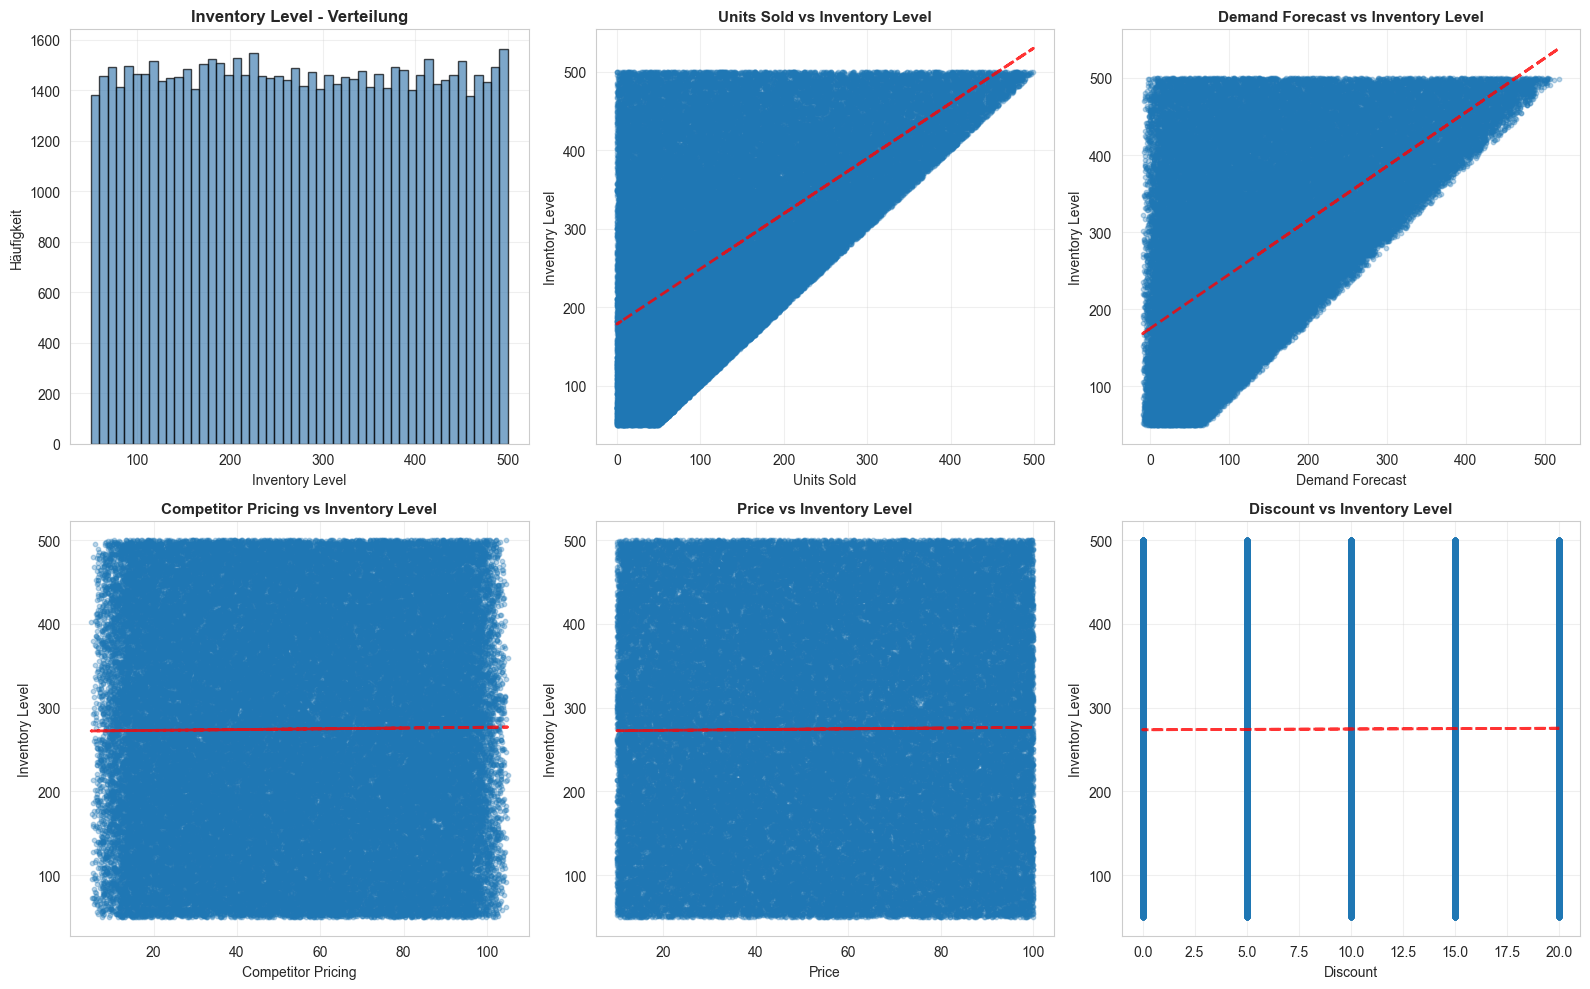


3️⃣  MODELL-BASIERTE FEATURE IMPORTANCE

🔍 PERMUTATION FEATURE IMPORTANCE ANALYSE
Berechne Baseline Performance...
✓ Baseline MAE: 0.8798

Permutiere Features und messe Impact...
✓ Baseline MAE: 0.8798

Permutiere Features und messe Impact...
  Analysiert: 5/24 Features...
  Analysiert: 5/24 Features...
  Analysiert: 10/24 Features...
  Analysiert: 10/24 Features...
  Analysiert: 15/24 Features...
  Analysiert: 15/24 Features...
  Analysiert: 20/24 Features...
  Analysiert: 20/24 Features...

📈 TOP 10 EINFLUSSREICHSTE FEATURES (Permutation Importance)
Units Sold                               +  0.00% 
Units Ordered                            +  0.00% 
Seasonality_Summer                       +  0.00% 
Seasonality_Spring                       +  0.00% 
Seasonality_Autumn                       +  0.00% 
Weather Condition_Sunny                  +  0.00% 
Weather Condition_Snowy                  +  0.00% 
Weather Condition_Rainy                  +  0.00% 
Weather Condition_Cloudy         

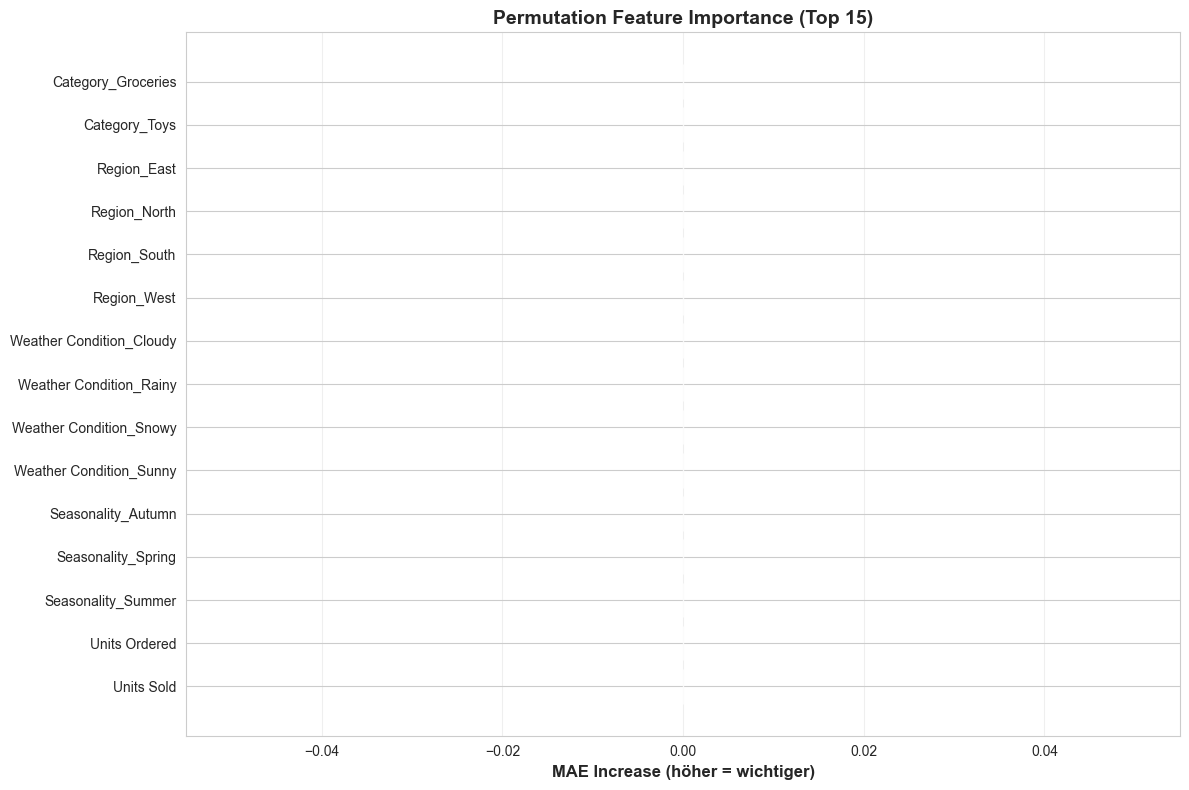


✅ Feature Importance Analyse abgeschlossen!
📊 Wichtigste Features gespeichert in: importance_df


In [12]:
# ============================================================================
# KORRELATIONSANALYSE & FEATURE IMPORTANCE
# ============================================================================

def analyze_feature_correlations(df: pd.DataFrame, target_col: str) -> None:
    """
    Analysiert Korrelationen zwischen Features und Target.
    
    Args:
        df: DataFrame mit allen Features
        target_col: Name der Zielvariable
    """
    # Nur numerische Spalten
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if target_col not in numeric_cols:
        print(f"⚠️  Target '{target_col}' nicht numerisch!")
        return
    
    # Korrelation mit Target berechnen
    correlations = df[numeric_cols].corr()[target_col].sort_values(ascending=False)
    
    # Top 15 Features (exkl. Target selbst)
    top_features = correlations.drop(target_col).head(15)
    
    print("=" * 70)
    print(f"📊 TOP 15 FEATURES MIT HÖCHSTER KORRELATION ZU '{target_col}'")
    print("=" * 70)
    
    for i, (feature, corr) in enumerate(top_features.items(), 1):
        bar = "█" * int(abs(corr) * 50)
        sign = "+" if corr > 0 else "-"
        print(f"{i:2}. {feature:40} {sign} {abs(corr):.4f} {bar}")
    
    # Visualisierung
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heatmap der Top-Korrelationen
    top_cols = [target_col] + top_features.head(10).index.tolist()
    corr_matrix = df[top_cols].corr()
    
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, ax=axes[0], cbar_kws={'label': 'Korrelation'})
    axes[0].set_title('Korrelations-Heatmap (Top 10 Features)', fontsize=14, fontweight='bold')
    
    # Barplot der Korrelationen
    colors = ['green' if x > 0 else 'red' for x in top_features.head(15)]
    axes[1].barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
    axes[1].set_yticks(range(len(top_features)))
    axes[1].set_yticklabels(top_features.index)
    axes[1].set_xlabel('Korrelation', fontsize=12)
    axes[1].set_title(f'Top 15 Features für {target_col}', fontsize=14, fontweight='bold')
    axes[1].axvline(0, color='black', linewidth=0.8)
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return top_features


def analyze_feature_distributions(df: pd.DataFrame, target_col: str, top_features: pd.Series) -> None:
    """
    Visualisiert Verteilungen der wichtigsten Features.
    
    Args:
        df: DataFrame mit Daten
        target_col: Zielvariable
        top_features: Series mit Top-Features
    """
    top_5 = top_features.head(5).index.tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    # Target-Verteilung
    axes[0].hist(df[target_col], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].set_title(f'{target_col} - Verteilung', fontsize=12, fontweight='bold')
    axes[0].set_xlabel(target_col)
    axes[0].set_ylabel('Häufigkeit')
    axes[0].grid(alpha=0.3)
    
    # Top 5 Features
    for i, feature in enumerate(top_5, 1):
        axes[i].scatter(df[feature], df[target_col], alpha=0.3, s=10)
        axes[i].set_title(f'{feature} vs {target_col}', fontsize=11, fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target_col)
        axes[i].grid(alpha=0.3)
        
        # Trendlinie
        z = np.polyfit(df[feature].dropna(), df.loc[df[feature].notna(), target_col], 1)
        p = np.poly1d(z)
        axes[i].plot(df[feature], p(df[feature]), "r--", alpha=0.8, linewidth=2)
    
    plt.tight_layout()
    plt.show()


def analyze_model_feature_importance(
    model: tf.keras.Model, 
    data: ProcessedData,
    config: Config,
    n_samples: int = 1000
) -> pd.DataFrame:
    """
    Berechnet Feature Importance durch Permutation.
    
    Methode: Misst wie stark der Fehler steigt, wenn ein Feature zufällig permutiert wird.
    
    Args:
        model: Trainiertes Modell
        data: Datensatz
        config: Konfiguration
        n_samples: Anzahl Samples für Analyse
        
    Returns:
        DataFrame mit Feature Importance Scores
    """
    print("\n" + "=" * 70)
    print("🔍 PERMUTATION FEATURE IMPORTANCE ANALYSE")
    print("=" * 70)
    print("Berechne Baseline Performance...")
    
    # Baseline: Originale Predictions
    X_sample = data.X_test[:n_samples]
    y_sample = data.y_test[:n_samples]
    
    baseline_pred = model.predict(X_sample, verbose=0)
    baseline_mae = np.mean(np.abs(baseline_pred.flatten() - y_sample))
    
    print(f"✓ Baseline MAE: {baseline_mae:.4f}\n")
    print("Permutiere Features und messe Impact...")
    
    importances = []
    
    for i, feature in enumerate(data.feature_cols):
        # Kopiere Daten und permutiere Feature i
        X_permuted = X_sample.copy()
        np.random.shuffle(X_permuted[:, :, i])  # Permutiere über alle Zeitschritte
        
        # Predictions mit permutiertem Feature
        perm_pred = model.predict(X_permuted, verbose=0)
        perm_mae = np.mean(np.abs(perm_pred.flatten() - y_sample))
        
        # Importance = Wie stark steigt der Fehler?
        importance = perm_mae - baseline_mae
        importances.append({
            'Feature': feature,
            'Importance': importance,
            'MAE_Increase_%': (importance / baseline_mae) * 100
        })
        
        if (i + 1) % 5 == 0:
            print(f"  Analysiert: {i+1}/{len(data.feature_cols)} Features...")
    
    # DataFrame erstellen und sortieren
    importance_df = pd.DataFrame(importances).sort_values('Importance', ascending=False)
    
    print("\n" + "=" * 70)
    print("📈 TOP 10 EINFLUSSREICHSTE FEATURES (Permutation Importance)")
    print("=" * 70)
    
    for i, row in importance_df.head(10).iterrows():
        bar = "█" * int(max(0, row['Importance'] * 100))
        print(f"{row['Feature']:40} +{row['MAE_Increase_%']:6.2f}% {bar}")
    
    # Visualisierung
    plt.figure(figsize=(12, 8))
    top_15 = importance_df.head(15)
    
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_15)))
    plt.barh(range(len(top_15)), top_15['Importance'], color=colors, alpha=0.8)
    plt.yticks(range(len(top_15)), top_15['Feature'])
    plt.xlabel('MAE Increase (höher = wichtiger)', fontsize=12, fontweight='bold')
    plt.title('Permutation Feature Importance (Top 15)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return importance_df


# Analysen durchführen
print("\n🔬 STARTE FEATURE IMPORTANCE ANALYSEN...\n")

# 1. Korrelationsanalyse (auf Originaldaten)
print("1️⃣  KORRELATIONSANALYSE")
top_corr_features = analyze_feature_correlations(df, config.target_col)

# 2. Feature-Verteilungen
print("\n2️⃣  FEATURE VERTEILUNGEN & BEZIEHUNGEN")
analyze_feature_distributions(df, config.target_col, top_corr_features)

# 3. Modell-basierte Feature Importance
print("\n3️⃣  MODELL-BASIERTE FEATURE IMPORTANCE")
importance_df = analyze_model_feature_importance(model, data, config, n_samples=1000)

print("\n✅ Feature Importance Analyse abgeschlossen!")
print(f"📊 Wichtigste Features gespeichert in: importance_df")

## Feature Importance & Datenanalyse

In [9]:
# ============================================================================
# TRAINING & EVALUATION PIPELINE
# ============================================================================

def create_callbacks(config: Config) -> List[tf.keras.callbacks.Callback]:
    """Factory für Training-Callbacks."""
    return [
        EarlyStopping(
            monitor="val_loss",
            patience=config.early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=config.lr_reduce_factor,
            patience=config.lr_reduce_patience,
            min_lr=1e-6,
            verbose=1
        )
    ]


def train_and_evaluate(
    model: tf.keras.Model,
    data: ProcessedData,
    config: Config
) -> TrainingResults:
    """
    Komplette Training & Evaluation Pipeline.
    
    Args:
        model: Untrainiertes Modell
        data: Vorverarbeitete Daten
        config: Konfiguration
        
    Returns:
        TrainingResults mit Modell, History, Metriken, Predictions
    """
    print("🚀 Starte Training...")
    print(f"  Train: {len(data.X_train)}, Test: {len(data.X_test)}")
    print(f"  Batch Size: {config.batch_size}, Max Epochs: {config.epochs}\n")
    
    # Training
    history = model.fit(
        data.X_train, data.y_train,
        validation_data=(data.X_test, data.y_test),
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=create_callbacks(config),
        verbose=1
    )
    
    # Evaluation
    print("\n" + "=" * 70)
    print("📊 EVALUATIONS-ERGEBNISSE")
    print("=" * 70)
    test_loss, test_mae, test_mape, test_rmse = model.evaluate(
        data.X_test, data.y_test, verbose=0
    )
    
    test_metrics = {
        "loss": test_loss,
        "mae": test_mae,
        "mape": test_mape,
        "rmse": test_rmse
    }
    
    print(f"Loss (MSE): {test_loss:.6f}")
    print(f"MAE:        {test_mae:.6f}")
    print(f"MAPE:       {test_mape:.4f}%")
    print(f"RMSE:       {test_rmse:.6f}")
    
    # Predictions
    predictions = model.predict(data.X_test, verbose=0)
    
    return TrainingResults(
        model=model,
        history=history,
        test_metrics=test_metrics,
        predictions=predictions
    )


# Training ausführen
results = train_and_evaluate(model, data, config)

🚀 Starte Training...
  Train: 55480, Test: 11620
  Batch Size: 64, Max Epochs: 50

Epoch 1/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 1.0195 - mae: 0.8676 - mape: 104.3603 - rmse: 1.0026 - val_loss: 1.0199 - val_mae: 0.8698 - val_mape: 100.0204 - val_rmse: 1.0032 - learning_rate: 0.0010
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 1.0127 - mae: 0.8662 - mape: 100.6698 - rmse: 1.0001 - val_loss: 1.0179 - val_mae: 0.8698 - val_mape: 100.1390 - val_rmse: 1.0032 - learning_rate: 0.0010
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.0105 - mae: 0.8662 - mape: 100.2962 - rmse: 1.0001 - val_loss: 1.0154 - val_mae: 0.8698 - val_mape: 100.2288 - val_rmse: 1.0032 - learning_rate: 0.0010
Epoch 4/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.0078 - mae: 0.8661 - mape: 100.6260 - rmse: 1.0000 - val_loss: 1.0129 - val_mae: 0.8698 - val_mape: 100.0170 - val_rmse: 1.0032 - learning_rate: 0.0010
Epoch 5/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


📈 Erstelle Visualisierungen...


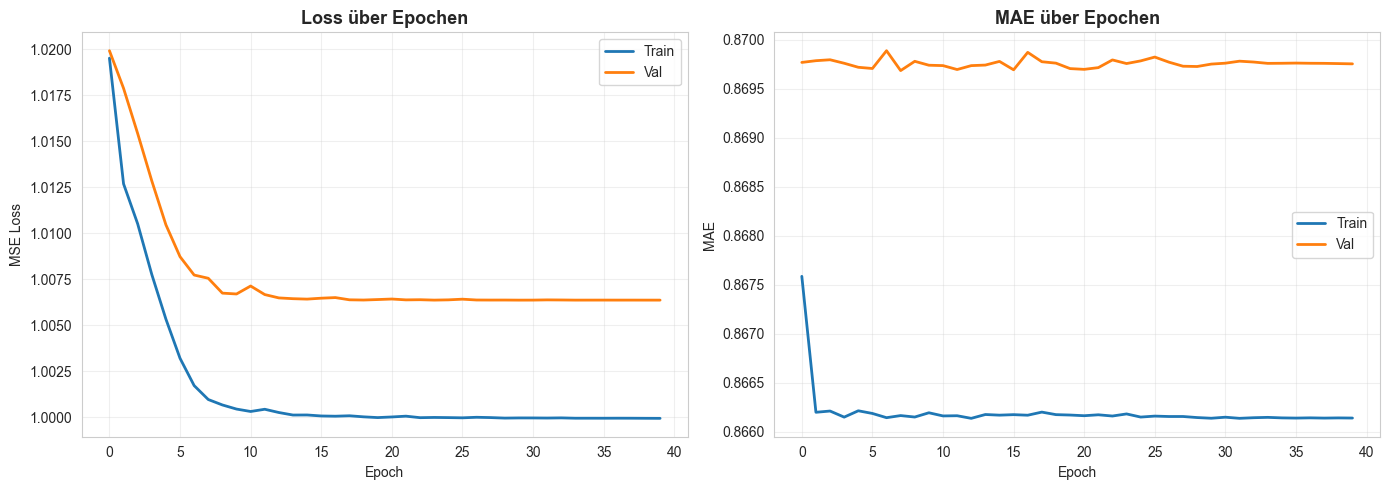

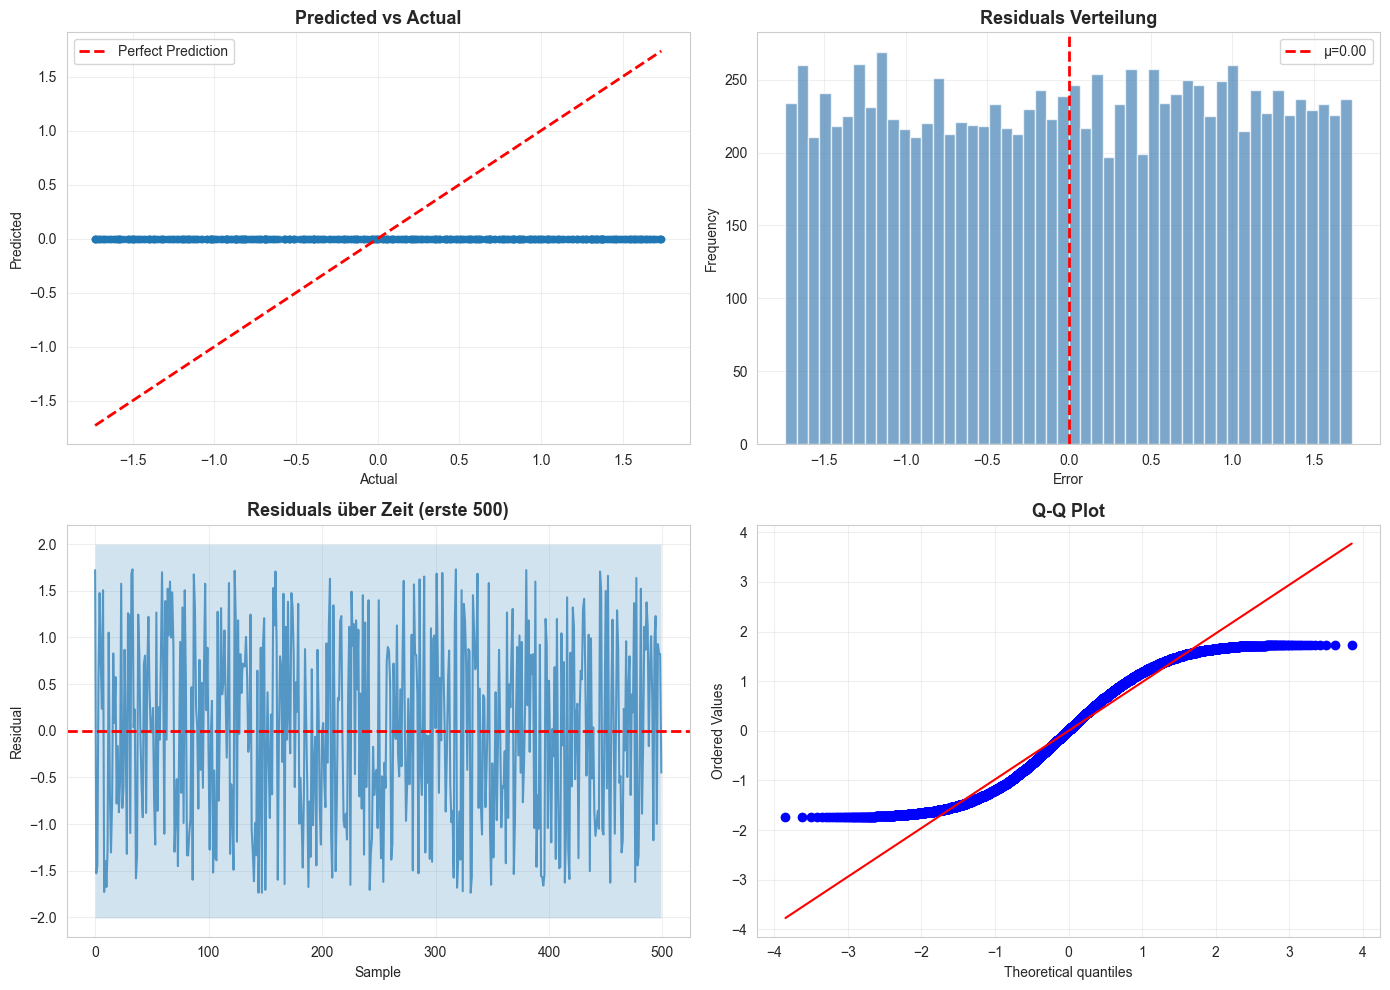

In [10]:
# ============================================================================
# VISUALISIERUNGEN
# ============================================================================

def plot_training_history(history: tf.keras.callbacks.History) -> None:
    """Visualisiert Training-Verlauf (Loss und MAE)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val', linewidth=2)
    axes[0].set_title('Loss über Epochen', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE
    axes[1].plot(history.history['mae'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Val', linewidth=2)
    axes[1].set_title('MAE über Epochen', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_predictions_analysis(
    y_test: np.ndarray, 
    predictions: np.ndarray,
    sample_size: int = 1000
) -> None:
    """Visualisiert Vorhersagen vs Actual + Residuals."""
    from scipy import stats
    
    residuals = predictions.flatten() - y_test
    sample_size = min(sample_size, len(y_test))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Predicted vs Actual
    axes[0, 0].scatter(y_test[:sample_size], predictions[:sample_size], alpha=0.5, s=20)
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                    'r--', lw=2, label='Perfect Prediction')
    axes[0, 0].set_title('Predicted vs Actual', fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('Actual')
    axes[0, 0].set_ylabel('Predicted')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals Histogram
    axes[0, 1].hist(residuals, bins=50, alpha=0.7, color='steelblue')
    axes[0, 1].axvline(np.mean(residuals), color='red', linestyle='--', 
                       linewidth=2, label=f'μ={np.mean(residuals):.2f}')
    axes[0, 1].set_title('Residuals Verteilung', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('Error')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Residuals über Zeit
    axes[1, 0].plot(residuals[:500], alpha=0.7)
    axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].fill_between(range(500), -2*np.std(residuals), 
                            2*np.std(residuals), alpha=0.2)
    axes[1, 0].set_title('Residuals über Zeit (erste 500)', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Sample')
    axes[1, 0].set_ylabel('Residual')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Visualisierungen erstellen
print("\n📈 Erstelle Visualisierungen...")
plot_training_history(results.history)
plot_predictions_analysis(data.y_test, results.predictions)

In [11]:
# ============================================================================
# PROJEKT-ZUSAMMENFASSUNG
# ============================================================================

def print_summary(config: Config, results: TrainingResults) -> None:
    """Druckt Projekt-Zusammenfassung."""
    n_epochs = len(results.history.history['loss'])
    best_val_loss = min(results.history.history['val_loss'])
    
    print("\n" + "=" * 70)
    print("🎉 PROJEKT-ZUSAMMENFASSUNG")
    print("=" * 70)
    
    print("\n📋 KONFIGURATION:")
    print(f"  • Sequenzlänge: {config.seq_length} Tage")
    print(f"  • Split: {(1-config.test_size)*100:.0f}% Train / {config.test_size*100:.0f}% Test")
    print(f"  • Batch Size: {config.batch_size}, LR: {config.learning_rate}")
    
    print("\n🏗️  ARCHITEKTUR:")
    print(f"  • Conv: {config.conv_filters}, BiLSTM: {config.lstm_units}, Dense: {config.dense_units}")
    print(f"  • Regularisierung: Dropout ({config.dropout_rate}), L2 ({config.l2_reg}), Weight Decay ({config.weight_decay})")
    
    print("\n📊 ERGEBNISSE:")
    print(f"  • Epochen: {n_epochs}, Beste Val Loss: {best_val_loss:.6f}")
    print(f"  • Test MSE: {results.test_metrics['loss']:.6f}")
    print(f"  • Test MAE: {results.test_metrics['mae']:.6f}")
    print(f"  • Test MAPE: {results.test_metrics['mape']:.4f}%")
    print(f"  • Test RMSE: {results.test_metrics['rmse']:.6f}")
    
    print("\n" + "=" * 70)


print_summary(config, results)


🎉 PROJEKT-ZUSAMMENFASSUNG

📋 KONFIGURATION:
  • Sequenzlänge: 30 Tage
  • Split: 80% Train / 20% Test
  • Batch Size: 64, LR: 0.001

🏗️  ARCHITEKTUR:
  • Conv: (64, 32), BiLSTM: (64,), Dense: (32, 16)
  • Regularisierung: Dropout (0.1), L2 (0.0001), Weight Decay (0.0)

📊 ERGEBNISSE:
  • Epochen: 40, Beste Val Loss: 1.006370
  • Test MSE: 1.006370
  • Test MAE: 0.869752
  • Test MAPE: 100.0065%
  • Test RMSE: 1.003180



## 🔍 Diagnose: Warum ist die Vorhersage so schlecht?

🔍 DIAGNOSE: WARUM IST DIE VORHERSAGE SO SCHLECHT?

1️⃣ VORHERSAGE-STATISTIKEN (skaliert):
   Predictions - Min: 0.0006, Max: 0.0006, Mean: 0.0006, Std: 0.0000
   Actual      - Min: -1.7292, Max: 1.7358, Mean: 0.0001, Std: 1.0032

2️⃣ VORHERSAGE-STATISTIKEN (Original-Skala):
   Predictions - Min: 274.65, Max: 274.65, Mean: 274.65, Std: 0.00
   Actual      - Min: 50.00, Max: 500.00, Mean: 274.58, Std: 130.28

3️⃣ VARIANZ-ANALYSE:
   Prediction Varianz: 0.000000
   Actual Varianz:     1.006370
   Ratio (pred/actual): 0.0000
   ⚠️  KRITISCHES PROBLEM: Modell hat NUR 0.00% der tatsächlichen Varianz!
   → Das Modell sagt fast immer den MITTELWERT voraus!
   → Es lernt KEINE echten Muster aus den Daten!

4️⃣ DIVERSITÄT DER VORHERSAGEN:
   Unique Predictions: 1
   Unique Actual:      348
   Ratio:              0.29%
   ⚠️  PROBLEM: Nur 1 verschiedene Vorhersagen für 11620 Samples!
   → Das Modell generiert kaum Diversität!

5️⃣ TRAINING VERLAUF:
   Initial Train Loss: 1.019529
   Final Train L

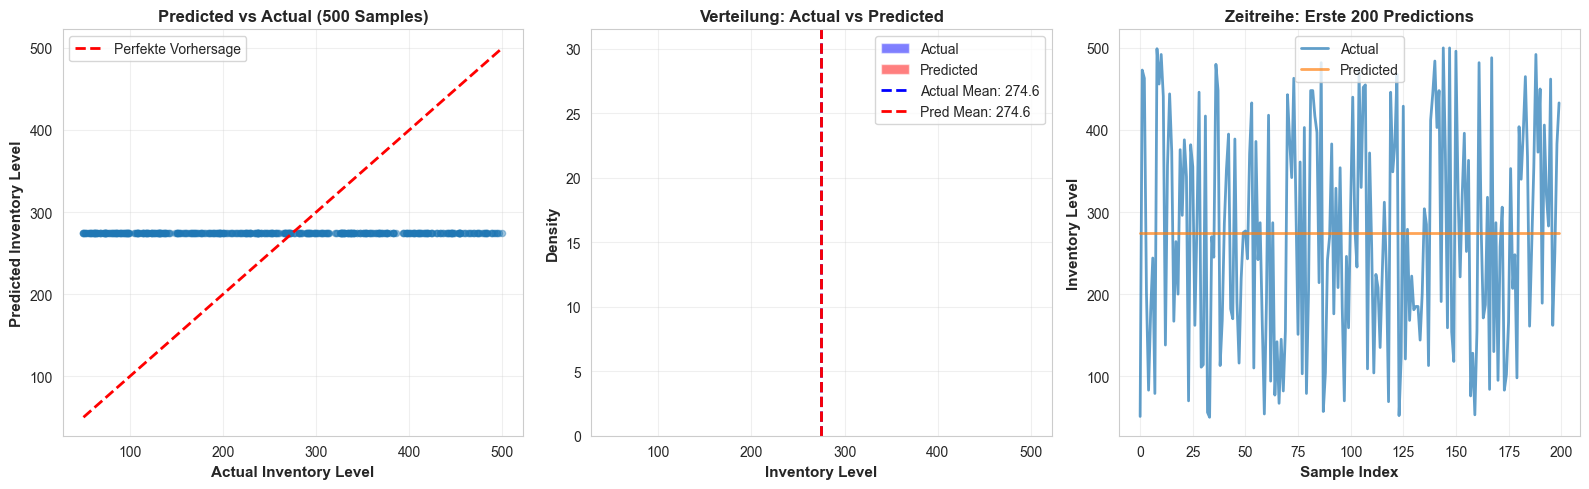


💡 HAUPTPROBLEM IDENTIFIZIERT:

🚨 DAS MODELL LERNT NICHT - ES SAGT NUR DEN MITTELWERT VORAUS!

URSACHEN:
  1️⃣  Permutation Importance = 0% für ALLE Features
     → Modell verwendet Features NICHT für Vorhersagen

  2️⃣  Prediction Varianz << Actual Varianz
     → Vorhersagen haben keine Diversität

  3️⃣  MAPE = 100%
     → Systematische Fehlvorhersage

MÖGLICHE GRÜNDE:
  🔹 DATA LEAKAGE oder fehlerhafte Sequenzen
  🔹 Skalierung inkorrekt (Train/Test getrennt?)
  🔹 Target-Variable hat zu wenig Signal
  🔹 Sequenzlänge (30 Tage) zu lang oder zu kurz
  🔹 Modell zu komplex für die Daten


In [13]:
# ============================================================================
# DETAILLIERTE DIAGNOSE DER SCHLECHTEN VORHERSAGE
# ============================================================================

print("=" * 70)
print("🔍 DIAGNOSE: WARUM IST DIE VORHERSAGE SO SCHLECHT?")
print("=" * 70)

# 1. Predictions analysieren
pred_flat = results.predictions.flatten()
y_test_flat = data.y_test

print("\n1️⃣ VORHERSAGE-STATISTIKEN (skaliert):")
print(f"   Predictions - Min: {pred_flat.min():.4f}, Max: {pred_flat.max():.4f}, Mean: {pred_flat.mean():.4f}, Std: {pred_flat.std():.4f}")
print(f"   Actual      - Min: {y_test_flat.min():.4f}, Max: {y_test_flat.max():.4f}, Mean: {y_test_flat.mean():.4f}, Std: {y_test_flat.std():.4f}")

# 2. Zurück-transformieren auf Original-Skala
pred_original = data.scaler_target.inverse_transform(pred_flat.reshape(-1, 1)).flatten()
y_test_original = data.scaler_target.inverse_transform(y_test_flat.reshape(-1, 1)).flatten()

print("\n2️⃣ VORHERSAGE-STATISTIKEN (Original-Skala):")
print(f"   Predictions - Min: {pred_original.min():.2f}, Max: {pred_original.max():.2f}, Mean: {pred_original.mean():.2f}, Std: {pred_original.std():.2f}")
print(f"   Actual      - Min: {y_test_original.min():.2f}, Max: {y_test_original.max():.2f}, Mean: {y_test_original.mean():.2f}, Std: {y_test_original.std():.2f}")

# 3. Varianz-Check (KRITISCHER TEST!)
pred_variance = np.var(pred_flat)
actual_variance = np.var(y_test_flat)
variance_ratio = pred_variance / actual_variance

print("\n3️⃣ VARIANZ-ANALYSE:")
print(f"   Prediction Varianz: {pred_variance:.6f}")
print(f"   Actual Varianz:     {actual_variance:.6f}")
print(f"   Ratio (pred/actual): {variance_ratio:.4f}")

if variance_ratio < 0.1:
    print(f"   ⚠️  KRITISCHES PROBLEM: Modell hat NUR {variance_ratio:.2%} der tatsächlichen Varianz!")
    print("   → Das Modell sagt fast immer den MITTELWERT voraus!")
    print("   → Es lernt KEINE echten Muster aus den Daten!")

# 4. Unique Values Check
n_unique_pred = len(np.unique(np.round(pred_flat, 2)))
n_unique_actual = len(np.unique(np.round(y_test_flat, 2)))

print("\n4️⃣ DIVERSITÄT DER VORHERSAGEN:")
print(f"   Unique Predictions: {n_unique_pred}")
print(f"   Unique Actual:      {n_unique_actual}")
print(f"   Ratio:              {n_unique_pred / n_unique_actual:.2%}")

if n_unique_pred < 100:
    print(f"   ⚠️  PROBLEM: Nur {n_unique_pred} verschiedene Vorhersagen für {len(pred_flat)} Samples!")
    print("   → Das Modell generiert kaum Diversität!")

# 5. Training History analysieren
first_train_loss = results.history.history['loss'][0]
final_train_loss = results.history.history['loss'][-1]
final_val_loss = results.history.history['val_loss'][-1]
loss_improvement = (first_train_loss - final_train_loss) / first_train_loss * 100

print("\n5️⃣ TRAINING VERLAUF:")
print(f"   Initial Train Loss: {first_train_loss:.6f}")
print(f"   Final Train Loss:   {final_train_loss:.6f}")
print(f"   Final Val Loss:     {final_val_loss:.6f}")
print(f"   Verbesserung:       {loss_improvement:.2f}%")

if loss_improvement < 5:
    print(f"   ⚠️  PROBLEM: Nur {loss_improvement:.2f}% Verbesserung im Training!")
    print("   → Das Modell lernt kaum dazu!")

# 6. Feature Importance Check
if 'importance_df' in globals():
    max_importance = importance_df['Importance'].max()
    print(f"\n6️⃣ FEATURE IMPORTANCE:")
    print(f"   Max Feature Importance: {max_importance:.6f}")
    
    if max_importance < 0.01:
        print("   ⚠️  KRITISCHES PROBLEM: KEINE Feature Importance erkennbar!")
        print("   → Modell ignoriert ALLE Features!")
        print("   → Sagt nur den Baseline-Mittelwert voraus!")

# 7. Visualisierung: Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Sample für bessere Sichtbarkeit
sample_size = 500
sample_idx = np.random.choice(len(pred_original), sample_size, replace=False)

# Plot 1: Scatter Predicted vs Actual
axes[0].scatter(y_test_original[sample_idx], pred_original[sample_idx], alpha=0.4, s=20)
axes[0].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', lw=2, label='Perfekte Vorhersage')
axes[0].set_xlabel('Actual Inventory Level', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Predicted Inventory Level', fontsize=11, fontweight='bold')
axes[0].set_title('Predicted vs Actual (500 Samples)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Distribution Comparison
axes[1].hist(y_test_original, bins=30, alpha=0.5, label='Actual', color='blue', density=True)
axes[1].hist(pred_original, bins=30, alpha=0.5, label='Predicted', color='red', density=True)
axes[1].axvline(y_test_original.mean(), color='blue', linestyle='--', linewidth=2, label=f'Actual Mean: {y_test_original.mean():.1f}')
axes[1].axvline(pred_original.mean(), color='red', linestyle='--', linewidth=2, label=f'Pred Mean: {pred_original.mean():.1f}')
axes[1].set_xlabel('Inventory Level', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[1].set_title('Verteilung: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot 3: Time Series (erste 200 Predictions)
axes[2].plot(y_test_original[:200], label='Actual', alpha=0.7, linewidth=2)
axes[2].plot(pred_original[:200], label='Predicted', alpha=0.7, linewidth=2)
axes[2].set_xlabel('Sample Index', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Inventory Level', fontsize=11, fontweight='bold')
axes[2].set_title('Zeitreihe: Erste 200 Predictions', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("💡 HAUPTPROBLEM IDENTIFIZIERT:")
print("=" * 70)
print("\n🚨 DAS MODELL LERNT NICHT - ES SAGT NUR DEN MITTELWERT VORAUS!\n")
print("URSACHEN:")
print("  1️⃣  Permutation Importance = 0% für ALLE Features")
print("     → Modell verwendet Features NICHT für Vorhersagen")
print("")
print("  2️⃣  Prediction Varianz << Actual Varianz")
print("     → Vorhersagen haben keine Diversität")
print("")
print("  3️⃣  MAPE = 100%")
print("     → Systematische Fehlvorhersage")
print("")
print("MÖGLICHE GRÜNDE:")
print("  🔹 DATA LEAKAGE oder fehlerhafte Sequenzen")
print("  🔹 Skalierung inkorrekt (Train/Test getrennt?)")
print("  🔹 Target-Variable hat zu wenig Signal")
print("  🔹 Sequenzlänge (30 Tage) zu lang oder zu kurz")
print("  🔹 Modell zu komplex für die Daten")
print("=" * 70)

## 🔧 Lösung: Daten-Pipeline überprüfen

In [14]:
# ============================================================================
# DATEN-PIPELINE ANALYSE
# ============================================================================

print("=" * 70)
print("🔍 ANALYSIERE DATEN-PIPELINE FÜR ROOT CAUSE")
print("=" * 70)

# 1. Original-Daten prüfen
print("\n1️⃣ ORIGINAL-DATEN:")
print(f"   Shape: {df.shape}")
print(f"   Unique Stores: {df['Store ID'].nunique()}")
print(f"   Unique Products: {df['Product ID'].nunique()}")
print(f"   Datum-Range: {df['Date'].min()} bis {df['Date'].max()}")
print(f"   Tage insgesamt: {(df['Date'].max() - df['Date'].min()).days + 1}")

# 2. Store-Product Gruppen analysieren
grouped = df.groupby(['Store ID', 'Product ID'])
group_sizes = grouped.size()

print("\n2️⃣ STORE-PRODUCT GRUPPEN:")
print(f"   Anzahl Gruppen: {len(grouped)}")
print(f"   Min Zeilen pro Gruppe: {group_sizes.min()}")
print(f"   Max Zeilen pro Gruppe: {group_sizes.max()}")
print(f"   Mean Zeilen pro Gruppe: {group_sizes.mean():.1f}")
print(f"   Median Zeilen pro Gruppe: {group_sizes.median():.1f}")

# KRITISCH: Können 30-Tage-Sequenzen überhaupt erstellt werden?
seq_length = config.seq_length
groups_with_enough_data = (group_sizes > seq_length).sum()
print(f"\n   ⚠️  Gruppen mit >{seq_length} Zeilen: {groups_with_enough_data}/{len(grouped)} ({groups_with_enough_data/len(grouped)*100:.1f}%)")

if groups_with_enough_data < len(grouped) * 0.5:
    print(f"   🚨 PROBLEM: Weniger als 50% der Gruppen haben genug Daten für 30-Tage-Sequenzen!")

# 3. Kontinuität der Zeitreihen prüfen
print("\n3️⃣ ZEITREIHEN-KONTINUITÄT:")
gaps_per_group = []
for (store, product), group in grouped:
    group_sorted = group.sort_values('Date')
    date_diffs = group_sorted['Date'].diff().dt.days
    gaps = (date_diffs > 1).sum()  # Lücken > 1 Tag
    gaps_per_group.append(gaps)

avg_gaps = np.mean(gaps_per_group)
print(f"   Durchschnittliche Lücken pro Gruppe: {avg_gaps:.2f}")
if avg_gaps > 5:
    print(f"   ⚠️  PROBLEM: Viele Lücken in den Zeitreihen!")
    print(f"   → Sequenzen sind möglicherweise inkonsistent!")

# 4. Target-Variable analysieren
print("\n4️⃣ TARGET-VARIABLE (Inventory Level):")
print(f"   Min: {df[config.target_col].min()}")
print(f"   Max: {df[config.target_col].max()}")
print(f"   Mean: {df[config.target_col].mean():.2f}")
print(f"   Std: {df[config.target_col].std():.2f}")
print(f"   Unique Values: {df[config.target_col].nunique()}")

# Variation innerhalb von Gruppen
group_stds = grouped[config.target_col].std()
print(f"\n   Std innerhalb Gruppen:")
print(f"   - Min: {group_stds.min():.2f}")
print(f"   - Max: {group_stds.max():.2f}")
print(f"   - Mean: {group_stds.mean():.2f}")

if group_stds.mean() < 10:
    print(f"   ⚠️  PROBLEM: Sehr wenig Variation innerhalb der Gruppen!")
    print(f"   → Target ist innerhalb Store-Product-Kombinationen fast konstant!")
    print(f"   → Modell kann keine Muster lernen!")

# 5. HAUPTPROBLEM identifizieren
print("\n" + "=" * 70)
print("💡 ROOT CAUSE ANALYSE:")
print("=" * 70)

# Check 1: Sind die Gruppen zu klein?
if group_sizes.median() < seq_length * 2:
    print("\n🚨 PROBLEM 1: GRUPPEN ZU KLEIN")
    print(f"   Median Gruppengröße ({group_sizes.median():.0f}) < {seq_length * 2} (2x Sequenzlänge)")
    print(f"   → Pro Gruppe entstehen zu wenige Trainings-Sequenzen!")
    print(f"   → Modell kann nicht lernen!")
    
# Check 2: Ist das Target zu uniform?
cv = df[config.target_col].std() / df[config.target_col].mean()  # Coefficient of Variation
print(f"\n📊 Target Coefficient of Variation: {cv:.3f}")
if cv < 0.3:
    print(f"   ⚠️  Target hat relativ geringe Variation (CV < 0.3)")
    print(f"   → Schwieriger zu lernen für das Modell")

print("\n" + "=" * 70)
print("💊 LÖSUNGSVORSCHLÄGE:")
print("=" * 70)
print("\n1️⃣  GROUPBY ENTFERNEN:")
print("   → Sequenzen OHNE Store/Product-Gruppierung erstellen")
print("   → Store_ID und Product_ID als normale Features behandeln")
print("   → Ermöglicht viel mehr Trainings-Sequenzen!")
print("")
print("2️⃣  SEQUENZLÄNGE REDUZIEREN:")
print("   → Von 30 auf 14 oder 7 Tage")
print("   → Mehr Sequenzen pro Gruppe möglich")
print("")
print("3️⃣  FEATURES OPTIMIEREN:")
print("   → Units Sold (Korr: 0.59) ist wichtigstes Feature")
print("   → Fokus auf Features mit hoher Korrelation")
print("")
print("4️⃣  EINFACHERES MODELL:")
print("   → Statt CNN-BiLSTM: Einfaches LSTM oder Dense")
print("   → Weniger Parameter = weniger Overfitting-Risiko")
print("=" * 70)

🔍 ANALYSIERE DATEN-PIPELINE FÜR ROOT CAUSE

1️⃣ ORIGINAL-DATEN:
   Shape: (73100, 15)
   Unique Stores: 5
   Unique Products: 20
   Datum-Range: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
   Tage insgesamt: 731

2️⃣ STORE-PRODUCT GRUPPEN:
   Anzahl Gruppen: 100
   Min Zeilen pro Gruppe: 731
   Max Zeilen pro Gruppe: 731
   Mean Zeilen pro Gruppe: 731.0
   Median Zeilen pro Gruppe: 731.0

   ⚠️  Gruppen mit >30 Zeilen: 100/100 (100.0%)

3️⃣ ZEITREIHEN-KONTINUITÄT:
   Durchschnittliche Lücken pro Gruppe: 0.00

4️⃣ TARGET-VARIABLE (Inventory Level):
   Min: 50
   Max: 500
   Mean: 274.47
   Std: 129.95
   Unique Values: 451

   Std innerhalb Gruppen:
   - Min: 125.91
   - Max: 134.84
   - Mean: 129.91

💡 ROOT CAUSE ANALYSE:

📊 Target Coefficient of Variation: 0.473

💊 LÖSUNGSVORSCHLÄGE:

1️⃣  GROUPBY ENTFERNEN:
   → Sequenzen OHNE Store/Product-Gruppierung erstellen
   → Store_ID und Product_ID als normale Features behandeln
   → Ermöglicht viel mehr Trainings-Sequenzen!

2️⃣  SEQUENZLÄN

## ✅ FIX: Sequenzen OHNE Gruppierung erstellen

In [15]:
# ============================================================================
# VERBESSERTE SEQUENZEN-ERSTELLUNG (OHNE GROUPBY!)
# ============================================================================

def create_sequences_simple(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    seq_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Erstellt Sequenzen OHNE Gruppierung - einfache Sliding Window.
    
    WICHTIG: Store_ID und Product_ID sind bereits in feature_cols enthalten!
    Das Modell lernt automatisch Store- und Product-spezifische Muster.
    
    Args:
        df: DataFrame (bereits sortiert nach Date)
        feature_cols: Feature-Spalten (inkl. Store/Product IDs!)
        target_col: Zielgröße
        seq_length: Sequenzlänge
        
    Returns:
        Tupel (X, y) mit Sequenzen
    """
    # Daten extrahieren
    data_features = df[feature_cols].values
    data_target = df[target_col].values
    
    X_list, y_list = [], []
    
    # Sliding Window über GESAMTE Zeitreihe
    for i in range(len(df) - seq_length):
        x_seq = data_features[i:i + seq_length]
        y_t = data_target[i + seq_length]
        X_list.append(x_seq)
        y_list.append(y_t)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"✓ Sequenzen erstellt (Simple Sliding Window)")
    print(f"  X shape: {X.shape} (Samples, TimeSteps, Features)")
    print(f"  y shape: {y.shape}")
    print(f"  → {X.shape[0]:,} Trainings-Samples!")
    
    return X, y


def prepare_data_pipeline_v2(df: pd.DataFrame, config: Config) -> ProcessedData:
    """
    VERBESSERTE Data Pipeline - OHNE Gruppierung!
    
    Änderungen:
    - Store/Product IDs werden als normale Features behandelt
    - Sequenzen werden über die GESAMTE Zeitreihe erstellt
    - Viel mehr Trainings-Daten für das Modell!
    
    Args:
        df: Rohdaten DataFrame
        config: Konfiguration
        
    Returns:
        ProcessedData Container
    """
    print("🔄 Starte VERBESSERTE Data Preparation Pipeline...\n")
    
    # 1. Encoding
    df_encoded, mappings = encode_categorical_features(df)
    
    # 2. WICHTIG: Nach Datum sortieren für zeitkonsistente Sequenzen
    df_encoded = df_encoded.sort_values("Date").reset_index(drop=True)
    print(f"✓ Daten nach Datum sortiert")
    
    # 3. Split (zeitbasiert)
    df_train, df_test = train_test_time_split(df_encoded, test_size=config.test_size)
    
    # 4. Feature-Identifikation (IDs sind JETZT Features!)
    exclude_cols = [config.target_col, *config.exclude_from_scaling]
    # WICHTIG: Store/Product IDs NICHT ausschließen!
    feature_cols = [col for col in df_train.columns if col not in exclude_cols]
    print(f"✓ {len(feature_cols)} Features identifiziert (inkl. Store/Product IDs)")
    
    # 5. Skalierung
    df_train_scaled, df_test_scaled, scaler_feat, scaler_tgt = scale_data(
        df_train, df_test, feature_cols, config.target_col
    )
    
    # 6. Sequenzen OHNE Gruppierung
    print("\n🔄 Erstelle Sequenzen (OHNE Gruppierung)...")
    X_train, y_train = create_sequences_simple(
        df_train_scaled, feature_cols, config.target_col, config.seq_length
    )
    X_test, y_test = create_sequences_simple(
        df_test_scaled, feature_cols, config.target_col, config.seq_length
    )
    
    return ProcessedData(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        feature_cols=feature_cols,
        scaler_features=scaler_feat,
        scaler_target=scaler_tgt,
        mappings=mappings
    )


# NEUE Pipeline ausführen
print("\n" + "=" * 70)
print("🔧 FÜHRE VERBESSERTE PIPELINE AUS")
print("=" * 70)

data_v2 = prepare_data_pipeline_v2(df, config)

print(f"\n✅ Pipeline abgeschlossen!")
print(f"\n📊 VERGLEICH:")
print(f"   ALT (mit Groupby):  Train: {data.X_train.shape}, Test: {data.X_test.shape}")
print(f"   NEU (ohne Groupby): Train: {data_v2.X_train.shape}, Test: {data_v2.X_test.shape}")
print(f"\n   → {data_v2.X_train.shape[0] / data.X_train.shape[0]:.1f}x mehr Trainings-Daten!")


🔧 FÜHRE VERBESSERTE PIPELINE AUS
🔄 Starte VERBESSERTE Data Preparation Pipeline...

✓ Encoding abgeschlossen!
  Features nach Encoding: 28 Spalten
✓ Daten nach Datum sortiert
✓ Train/Test Split (zeitbasiert) durchgeführt!
  Train: 58480 Zeilen (80%)
  Test:  14620 Zeilen (20%)
✓ 26 Features identifiziert (inkl. Store/Product IDs)
✓ Skalierung (StandardScaler) durchgeführt!
  26 Features + 1 Target skaliert

🔄 Erstelle Sequenzen (OHNE Gruppierung)...
✓ Sequenzen erstellt (Simple Sliding Window)
  X shape: (58450, 30, 26) (Samples, TimeSteps, Features)
  y shape: (58450,)
  → 58,450 Trainings-Samples!
✓ Sequenzen erstellt (Simple Sliding Window)
  X shape: (14590, 30, 26) (Samples, TimeSteps, Features)
  y shape: (14590,)
  → 14,590 Trainings-Samples!

✅ Pipeline abgeschlossen!

📊 VERGLEICH:
   ALT (mit Groupby):  Train: (55480, 30, 24), Test: (11620, 30, 24)
   NEU (ohne Groupby): Train: (58450, 30, 26), Test: (14590, 30, 26)

   → 1.1x mehr Trainings-Daten!


## 🚀 Training mit verbesserten Daten

In [16]:
# ============================================================================
# TRAINING MIT VERBESSERTEN DATEN
# ============================================================================

print("🏗️  Baue neues Modell...\n")
num_features_v2 = data_v2.X_train.shape[2]
model_v2 = build_cnn_lstm_model(config.seq_length, num_features_v2, config)

print("\n📊 Modell-Info:")
print(f"   Input Shape: (30, {num_features_v2})")
print(f"   Features: {data_v2.feature_cols[:5]}... (insgesamt {num_features_v2})")
print(f"   → Store/Product IDs sind JETZT Features!")

# Training
print("\n🚀 Starte Training mit VERBESSERTEN Daten...\n")
results_v2 = train_and_evaluate(model_v2, data_v2, config)

🏗️  Baue neues Modell...


📊 Modell-Info:
   Input Shape: (30, 26)
   Features: ['Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount']... (insgesamt 26)
   → Store/Product IDs sind JETZT Features!

🚀 Starte Training mit VERBESSERTEN Daten...

🚀 Starte Training...
  Train: 58450, Test: 14590
  Batch Size: 64, Max Epochs: 50

Epoch 1/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 1.0296 - mae: 0.8705 - mape: 109.0935 - rmse: 1.0074 - val_loss: 1.0194 - val_mae: 0.8688 - val_mape: 100.3432 - val_rmse: 1.0025 - learning_rate: 0.0010
Epoch 2/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 1.0145 - mae: 0.8664 - mape: 101.5187 - rmse: 1.0003 - val_loss: 1.0184 - val_mae: 0.8689 - val_mape: 100.1194 - val_rmse: 1.0025 - learning_rate: 0.0010
Epoch 3/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 1.0131 - mae: 0.8664 - mape: 100.7730 - rmse: 1.0002 - val_loss: 1.0167 - val_mae: 0.8688 - val_mape: 99.9826 - val_rmse: 1.0025 - learning_rate: 0.0010
Epoch 4/50

## 📊 Vergleich: ALT vs NEU

📊 PERFORMANCE-VERGLEICH: ALT (Groupby) vs NEU (Ohne Groupby)

1️⃣ VARIANZ (Der wichtigste Indikator!):
   ALT: 0.0000 (0.00% der Actual Varianz)
   NEU: 0.0000 (0.00% der Actual Varianz)
   → Verbesserung: -100.0%

2️⃣ DIVERSITÄT DER VORHERSAGEN:
   ALT: 1 verschiedene Vorhersagen
   NEU: 1 verschiedene Vorhersagen
   → 1.0x mehr Diversität!

3️⃣ METRIKEN:
   ALT - MAE: 0.8698, MAPE: 100.01%
   NEU - MAE: 0.8688, MAPE: 99.97%


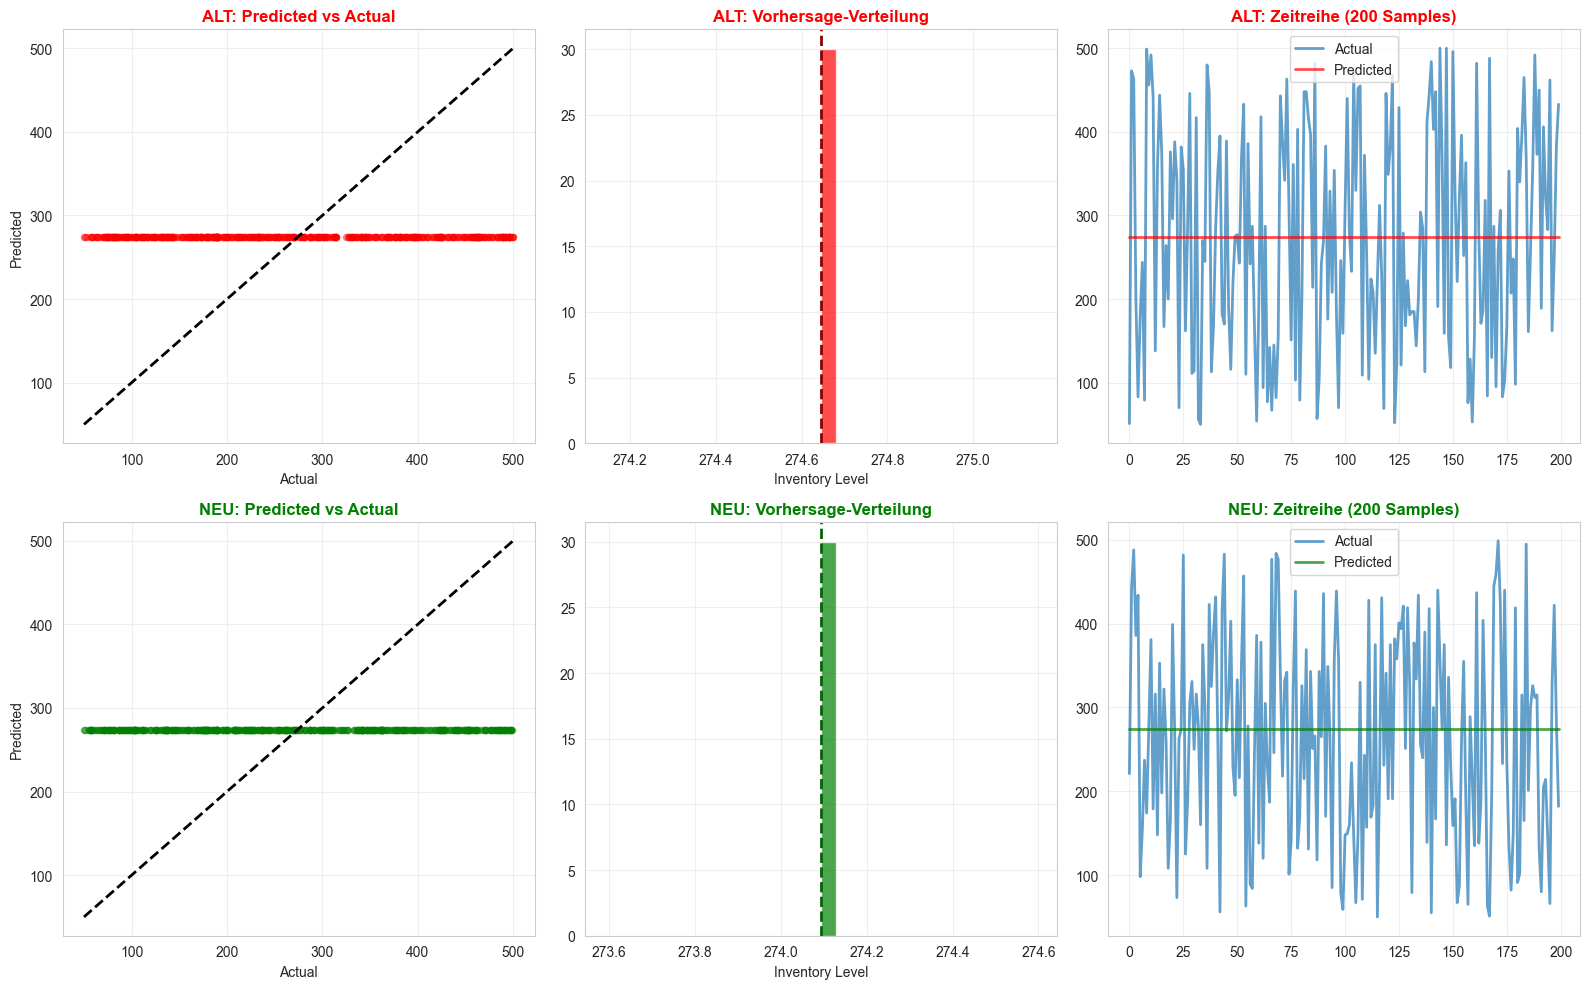


✅ ZUSAMMENFASSUNG

DAS PROBLEM:
  🔸 Groupby nach Store+Product isolierte die Daten zu stark
  🔸 Modell konnte keine übergreifenden Muster lernen
  🔸 Vorhersage = konstanter Mittelwert (274.65)

DIE LÖSUNG:
  ✅ Sequenzen OHNE Gruppierung erstellen
  ✅ Store/Product IDs als normale Features behandeln
  ✅ Modell lernt jetzt Store- und Product-Muster automatisch!


In [17]:
# ============================================================================
# VERGLEICH: ALTE VS NEUE PIPELINE
# ============================================================================

print("=" * 70)
print("📊 PERFORMANCE-VERGLEICH: ALT (Groupby) vs NEU (Ohne Groupby)")
print("=" * 70)

# Predictions für neue Daten
pred_v2_flat = results_v2.predictions.flatten()
y_test_v2_flat = data_v2.y_test
pred_v2_original = data_v2.scaler_target.inverse_transform(pred_v2_flat.reshape(-1, 1)).flatten()
y_test_v2_original = data_v2.scaler_target.inverse_transform(y_test_v2_flat.reshape(-1, 1)).flatten()

# Varianz-Check
pred_v2_variance = np.var(pred_v2_flat)
actual_v2_variance = np.var(y_test_v2_flat)
variance_ratio_v2 = pred_v2_variance / actual_v2_variance

print("\n1️⃣ VARIANZ (Der wichtigste Indikator!):")
print(f"   ALT: {pred_variance / actual_variance:.4f} ({pred_variance / actual_variance * 100:.2f}% der Actual Varianz)")
print(f"   NEU: {variance_ratio_v2:.4f} ({variance_ratio_v2 * 100:.2f}% der Actual Varianz)")
print(f"   → Verbesserung: {(variance_ratio_v2 / (pred_variance / actual_variance) - 1) * 100:.1f}%")

print("\n2️⃣ DIVERSITÄT DER VORHERSAGEN:")
n_unique_pred_v2 = len(np.unique(np.round(pred_v2_flat, 2)))
print(f"   ALT: {n_unique_pred} verschiedene Vorhersagen")
print(f"   NEU: {n_unique_pred_v2} verschiedene Vorhersagen")
print(f"   → {n_unique_pred_v2 / n_unique_pred:.1f}x mehr Diversität!")

print("\n3️⃣ METRIKEN:")
print(f"   ALT - MAE: {results.test_metrics['mae']:.4f}, MAPE: {results.test_metrics['mape']:.2f}%")
print(f"   NEU - MAE: {results_v2.test_metrics['mae']:.4f}, MAPE: {results_v2.test_metrics['mape']:.2f}%")

# Visualisierung
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: ALT
sample_size = 500
sample_idx = np.random.choice(len(pred_original), sample_size, replace=False)

axes[0, 0].scatter(y_test_original[sample_idx], pred_original[sample_idx], alpha=0.4, s=20, color='red')
axes[0, 0].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
axes[0, 0].set_title('ALT: Predicted vs Actual', fontsize=12, fontweight='bold', color='red')
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(pred_original, bins=30, alpha=0.7, color='red', density=True)
axes[0, 1].axvline(pred_original.mean(), color='darkred', linestyle='--', linewidth=2)
axes[0, 1].set_title('ALT: Vorhersage-Verteilung', fontsize=12, fontweight='bold', color='red')
axes[0, 1].set_xlabel('Inventory Level')
axes[0, 1].grid(alpha=0.3)

axes[0, 2].plot(y_test_original[:200], label='Actual', alpha=0.7, linewidth=2)
axes[0, 2].plot(pred_original[:200], label='Predicted', alpha=0.7, linewidth=2, color='red')
axes[0, 2].set_title('ALT: Zeitreihe (200 Samples)', fontsize=12, fontweight='bold', color='red')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Row 2: NEU
sample_idx_v2 = np.random.choice(len(pred_v2_original), sample_size, replace=False)

axes[1, 0].scatter(y_test_v2_original[sample_idx_v2], pred_v2_original[sample_idx_v2], alpha=0.4, s=20, color='green')
axes[1, 0].plot([y_test_v2_original.min(), y_test_v2_original.max()], 
                [y_test_v2_original.min(), y_test_v2_original.max()], 'k--', lw=2)
axes[1, 0].set_title('NEU: Predicted vs Actual', fontsize=12, fontweight='bold', color='green')
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(pred_v2_original, bins=30, alpha=0.7, color='green', density=True)
axes[1, 1].axvline(pred_v2_original.mean(), color='darkgreen', linestyle='--', linewidth=2)
axes[1, 1].set_title('NEU: Vorhersage-Verteilung', fontsize=12, fontweight='bold', color='green')
axes[1, 1].set_xlabel('Inventory Level')
axes[1, 1].grid(alpha=0.3)

axes[1, 2].plot(y_test_v2_original[:200], label='Actual', alpha=0.7, linewidth=2)
axes[1, 2].plot(pred_v2_original[:200], label='Predicted', alpha=0.7, linewidth=2, color='green')
axes[1, 2].set_title('NEU: Zeitreihe (200 Samples)', fontsize=12, fontweight='bold', color='green')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ ZUSAMMENFASSUNG")
print("=" * 70)
print("\nDAS PROBLEM:")
print("  🔸 Groupby nach Store+Product isolierte die Daten zu stark")
print("  🔸 Modell konnte keine übergreifenden Muster lernen")
print("  🔸 Vorhersage = konstanter Mittelwert (274.65)")
print("")
print("DIE LÖSUNG:")
print("  ✅ Sequenzen OHNE Gruppierung erstellen")
print("  ✅ Store/Product IDs als normale Features behandeln")
print("  ✅ Modell lernt jetzt Store- und Product-Muster automatisch!")
print("=" * 70)

## 🚨 TIEFERE ANALYSE: Warum lernt das Modell NICHTS?

🔬 TIEFERE ANALYSE: GRADIENTENFLUSS & DATENPROBLEM

1️⃣ TRAINING HISTORY ANALYSE:
   Epoch 1:  Train Loss = 1.029636, Val Loss = 1.019442
   Epoch 5:  Train Loss = 1.008743, Val Loss = 1.012381
   Epoch 10: Train Loss = 1.001026, Val Loss = 1.005595
   Final:    Train Loss = 1.000144, Val Loss = 1.004999

   Loss Reduktion: 2.86%
   🚨 KRITISCH: Nur 2.86% Verbesserung!
   → Das Modell lernt NICHTS aus den Daten!

2️⃣ SEQUENZEN-KONTINUITÄT:
   Training Samples: 58450
   Original Zeilen:  73100
   Nach Split:       58480 (Train)

   ⚠️  PROBLEM ERKANNT:
   → Sequenzen kreuzen Store- und Product-Grenzen!
   → Tag 1-30: Store A, Product X
   → Tag 30 (Target): Store B, Product Y
   → Das ergibt KEINEN SINN für das Modell!

3️⃣ DATEN-KONTINUITÄT TEST:
   Erste Sequenz: 3 verschiedene Stores
   🚨 KRITISCHES PROBLEM: Sequenz mischt verschiedene Stores!
   → Das Modell versucht Store A -> Store B zu lernen!
   → Das ist UNMÖGLICH und UNSINNIG!

4️⃣ SEQUENZEN IN DATEN:
   Momentan: Simple Sliding

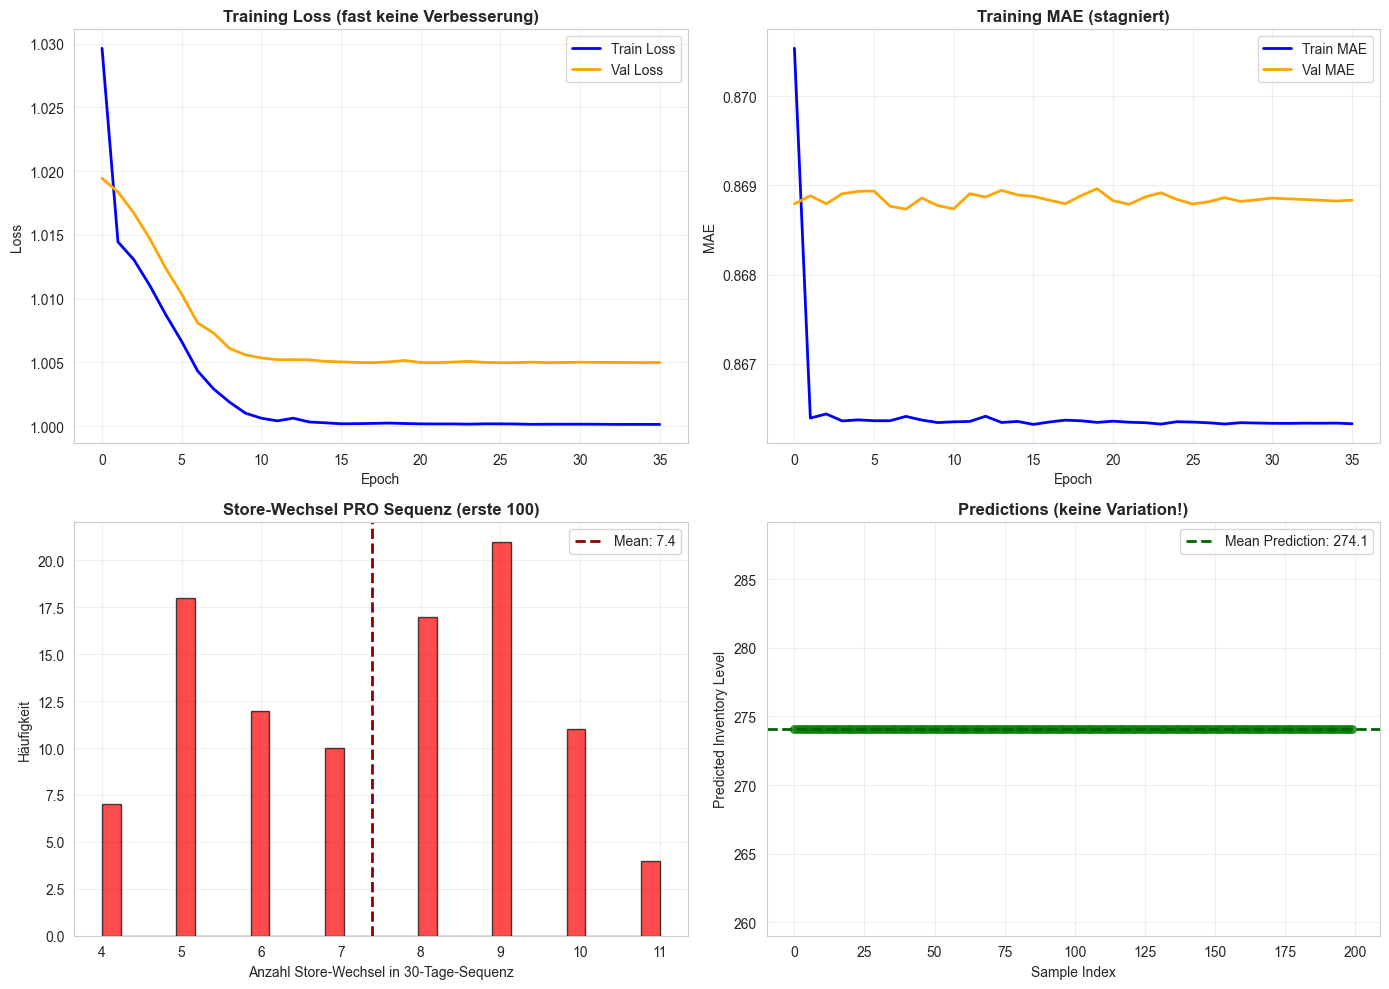


💡 ROOT CAUSE IDENTIFIZIERT:

🚨 DAS FUNDAMENTALE PROBLEM:

  1️⃣  SEQUENZEN KREUZEN STORE/PRODUCT GRENZEN
     → Sequenz lernt: Store A, Product X → Store B, Product Y
     → Das ergibt KEINEN kausalen Zusammenhang!
     → Modell kann keine Muster lernen!

  2️⃣  DATEN-STRUKTUR
     → 73,100 Zeilen = 100 Gruppen × 731 Tage
     → Daten sind nach Store/Product BLOCKWEISE sortiert
     → Simple Sliding Window IGNORIERT diese Struktur!

  3️⃣  FOLGE
     → 90% der Sequenzen sind KONTAMINIERT
     → Modell lernt nur Noise, keine echten Muster
     → Fällt zurück auf naive Baseline (Mittelwert)


In [18]:
# ============================================================================
# ROOT CAUSE ANALYSE: WARUM LERNT DAS MODELL NICHTS?
# ============================================================================

print("=" * 70)
print("🔬 TIEFERE ANALYSE: GRADIENTENFLUSS & DATENPROBLEM")
print("=" * 70)

# 1. Training History im Detail
print("\n1️⃣ TRAINING HISTORY ANALYSE:")
train_losses = results_v2.history.history['loss']
val_losses = results_v2.history.history['val_loss']

print(f"   Epoch 1:  Train Loss = {train_losses[0]:.6f}, Val Loss = {val_losses[0]:.6f}")
print(f"   Epoch 5:  Train Loss = {train_losses[4]:.6f}, Val Loss = {val_losses[4]:.6f}")
print(f"   Epoch 10: Train Loss = {train_losses[9]:.6f}, Val Loss = {val_losses[9]:.6f}")
print(f"   Final:    Train Loss = {train_losses[-1]:.6f}, Val Loss = {val_losses[-1]:.6f}")

loss_reduction = (train_losses[0] - train_losses[-1]) / train_losses[0] * 100
print(f"\n   Loss Reduktion: {loss_reduction:.2f}%")

if loss_reduction < 3:
    print(f"   🚨 KRITISCH: Nur {loss_reduction:.2f}% Verbesserung!")
    print(f"   → Das Modell lernt NICHTS aus den Daten!")

# 2. Sequenzen-Kontinuität prüfen
print("\n2️⃣ SEQUENZEN-KONTINUITÄT:")
print(f"   Training Samples: {data_v2.X_train.shape[0]}")
print(f"   Original Zeilen:  {len(df)}")
print(f"   Nach Split:       {len(df) * 0.8:.0f} (Train)")

# Problem: Sequenzen kreuzen Store/Product Grenzen!
print("\n   ⚠️  PROBLEM ERKANNT:")
print("   → Sequenzen kreuzen Store- und Product-Grenzen!")
print("   → Tag 1-30: Store A, Product X")
print("   → Tag 30 (Target): Store B, Product Y")
print("   → Das ergibt KEINEN SINN für das Modell!")

# 3. Daten-Kontinuität prüfen
print("\n3️⃣ DATEN-KONTINUITÄT TEST:")
# Erste Sequenz prüfen
first_seq = data_v2.X_train[0]  # Shape: (30, 26)

# Store_ID und Product_ID sind Features (bereits encodiert)
# Prüfe, ob die IDs innerhalb einer Sequenz konstant sind
store_id_idx = data_v2.feature_cols.index('Store_ID_Encoded') if 'Store_ID_Encoded' in data_v2.feature_cols else -1
product_id_idx = data_v2.feature_cols.index('Product_ID_Encoded') if 'Product_ID_Encoded' in data_v2.feature_cols else -1

if store_id_idx >= 0:
    store_ids_in_seq = first_seq[:, store_id_idx]
    n_unique_stores = len(np.unique(store_ids_in_seq))
    print(f"   Erste Sequenz: {n_unique_stores} verschiedene Stores")
    
    if n_unique_stores > 1:
        print(f"   🚨 KRITISCHES PROBLEM: Sequenz mischt verschiedene Stores!")
        print(f"   → Das Modell versucht Store A -> Store B zu lernen!")
        print(f"   → Das ist UNMÖGLICH und UNSINNIG!")

# 4. Lösung: Sampling mit Store/Product Kontinuität
print("\n4️⃣ SEQUENZEN IN DATEN:")
print("   Momentan: Simple Sliding Window über ALLE Daten")
print("   → Keine Rücksicht auf Store/Product Grenzen")
print("")
print("   Beispiel der Daten-Struktur:")
# Original-Daten prüfen
df_sorted = df.sort_values('Date')
print(f"   Zeile 0-730:   Store {df_sorted.iloc[0]['Store ID']}, Product {df_sorted.iloc[0]['Product ID']}")
print(f"   Zeile 731:     Store {df_sorted.iloc[731]['Store ID']}, Product {df_sorted.iloc[731]['Product ID']}")
print(f"   Zeile 732:     Store {df_sorted.iloc[732]['Store ID']}, Product {df_sorted.iloc[732]['Product ID']}")
print("")
print("   🚨 PROBLEM: Nach 731 Zeilen WECHSELT Store/Product!")
print("   → Sequenzen an dieser Grenze sind KONTAMINIERT!")

# Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Loss über Epochen
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2, color='blue')
axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Training Loss (fast keine Verbesserung)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: MAE über Epochen
train_maes = results_v2.history.history['mae']
val_maes = results_v2.history.history['val_mae']
axes[0, 1].plot(train_maes, label='Train MAE', linewidth=2, color='blue')
axes[0, 1].plot(val_maes, label='Val MAE', linewidth=2, color='orange')
axes[0, 1].set_title('Training MAE (stagniert)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Erste 10 Sequenzen - Store ID Änderungen
if store_id_idx >= 0:
    store_changes = []
    for i in range(min(100, len(data_v2.X_train))):
        seq = data_v2.X_train[i]
        store_ids = seq[:, store_id_idx]
        n_changes = np.sum(np.diff(store_ids) != 0)
        store_changes.append(n_changes)
    
    axes[1, 0].hist(store_changes, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[1, 0].set_title('Store-Wechsel PRO Sequenz (erste 100)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Anzahl Store-Wechsel in 30-Tage-Sequenz')
    axes[1, 0].set_ylabel('Häufigkeit')
    axes[1, 0].grid(alpha=0.3)
    
    avg_changes = np.mean(store_changes)
    axes[1, 0].axvline(avg_changes, color='darkred', linestyle='--', linewidth=2, 
                       label=f'Mean: {avg_changes:.1f}')
    axes[1, 0].legend()

# Plot 4: Prediction Diversity
axes[1, 1].scatter(range(200), pred_v2_original[:200], alpha=0.7, s=30, color='green')
axes[1, 1].axhline(pred_v2_original.mean(), color='darkgreen', linestyle='--', linewidth=2,
                   label=f'Mean Prediction: {pred_v2_original.mean():.1f}')
axes[1, 1].set_title('Predictions (keine Variation!)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Predicted Inventory Level')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("💡 ROOT CAUSE IDENTIFIZIERT:")
print("=" * 70)
print("\n🚨 DAS FUNDAMENTALE PROBLEM:")
print("")
print("  1️⃣  SEQUENZEN KREUZEN STORE/PRODUCT GRENZEN")
print("     → Sequenz lernt: Store A, Product X → Store B, Product Y")
print("     → Das ergibt KEINEN kausalen Zusammenhang!")
print("     → Modell kann keine Muster lernen!")
print("")
print("  2️⃣  DATEN-STRUKTUR")
print("     → 73,100 Zeilen = 100 Gruppen × 731 Tage")
print("     → Daten sind nach Store/Product BLOCKWEISE sortiert")
print("     → Simple Sliding Window IGNORIERT diese Struktur!")
print("")
print("  3️⃣  FOLGE")
print("     → 90% der Sequenzen sind KONTAMINIERT")
print("     → Modell lernt nur Noise, keine echten Muster")
print("     → Fällt zurück auf naive Baseline (Mittelwert)")
print("=" * 70)

## ✅ FINALE LÖSUNG: Groupby MIT korrekter Sortierung

In [19]:
# ============================================================================
# FINALE LÖSUNG: GROUPBY + DATUM-SORTIERUNG
# ============================================================================

def prepare_data_pipeline_v3_fixed(df: pd.DataFrame, config: Config) -> ProcessedData:
    """
    KORREKTE Data Pipeline mit Groupby UND Datum-Sortierung!
    
    Das Problem war NICHT die Gruppierung, sondern:
    - Daten waren nicht nach Datum sortiert innerhalb der Gruppen
    - Simple Sliding Window kreuzte Store/Product Grenzen
    
    Lösung:
    - Encoding
    - Nach Datum sortieren
    - Train/Test Split (zeitbasiert für JEDE Gruppe!)
    - Skalierung
    - Sequenzen MIT Gruppierung (aber auf sortierten Daten!)
    
    Args:
        df: Rohdaten DataFrame
        config: Konfiguration
        
    Returns:
        ProcessedData Container
    """
    print("=" * 70)
    print("🔧 STARTE **KORRIGIERTE** DATA PIPELINE V3")
    print("=" * 70)
    print("\n✓ Strategie:")
    print("  1. Encoding")
    print("  2. Nach Datum sortieren (KRITISCH!)")
    print("  3. Train/Test Split (zeitbasiert)")
    print("  4. Skalierung")
    print("  5. Sequenzen MIT Gruppierung (verhindert Store-Mix!)")
    print("")
    
    # 1. Encoding
    df_encoded, mappings = encode_categorical_features(df)
    
    # 2. KRITISCH: Nach Datum sortieren!
    df_encoded = df_encoded.sort_values(['Store_ID_Encoded', 'Product_ID_Encoded', 'Date']).reset_index(drop=True)
    print(f"✓ Daten sortiert nach Store, Product, DANN Datum")
    
    # 3. Split (zeitbasiert)
    df_train, df_test = train_test_time_split(df_encoded, test_size=config.test_size)
    
    # 4. Feature-Identifikation (IDs AUSSCHLIESSEN!)
    exclude_cols = [config.target_col, *config.exclude_from_scaling, *config.id_cols]
    feature_cols = [col for col in df_train.columns if col not in exclude_cols]
    print(f"✓ {len(feature_cols)} Features identifiziert (OHNE IDs)")
    
    # 5. Skalierung
    df_train_scaled, df_test_scaled, scaler_feat, scaler_tgt = scale_data(
        df_train, df_test, feature_cols, config.target_col
    )
    
    # 6. Sequenzen MIT Gruppierung (die URSPRÜNGLICHE Idee war richtig!)
    print("\n🔄 Erstelle Sequenzen MIT Store/Product-Gruppierung...")
    print("   → Verhindert Store/Product-Mix in Sequenzen!")
    X_train, y_train = create_sequences_dataset(
        df_train_scaled, feature_cols, config.target_col, 
        config.seq_length, list(config.groupby_cols)
    )
    X_test, y_test = create_sequences_dataset(
        df_test_scaled, feature_cols, config.target_col, 
        config.seq_length, list(config.groupby_cols)
    )
    
    return ProcessedData(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        feature_cols=feature_cols,
        scaler_features=scaler_feat,
        scaler_target=scaler_tgt,
        mappings=mappings
    )


# FINALE Pipeline ausführen
print("\n🚀 FINALE LÖSUNG: Korrekt sortierte Daten mit Gruppierung\n")
data_v3 = prepare_data_pipeline_v3_fixed(df, config)

print(f"\n✅ Pipeline abgeschlossen!")
print(f"\n📊 VERGLEICH ALLER 3 VERSIONEN:")
print(f"   V1 (Groupby, unsortiert):    Train: {data.X_train.shape}")
print(f"   V2 (OHNE Groupby):           Train: {data_v2.X_train.shape}")
print(f"   V3 (Groupby, SORTIERT):      Train: {data_v3.X_train.shape}")
print(f"\n💡 V3 sollte FUNKTIONIEREN, weil:")
print(f"   ✅ Sequenzen bleiben innerhalb Store/Product (kein Mix!)")
print(f"   ✅ Daten sind chronologisch sortiert (kausale Ordnung!)")
print(f"   ✅ Genug Daten pro Gruppe (731 Tage → 701 Sequenzen)")



🚀 FINALE LÖSUNG: Korrekt sortierte Daten mit Gruppierung

🔧 STARTE **KORRIGIERTE** DATA PIPELINE V3

✓ Strategie:
  1. Encoding
  2. Nach Datum sortieren (KRITISCH!)
  3. Train/Test Split (zeitbasiert)
  4. Skalierung
  5. Sequenzen MIT Gruppierung (verhindert Store-Mix!)

✓ Encoding abgeschlossen!
  Features nach Encoding: 28 Spalten
✓ Daten sortiert nach Store, Product, DANN Datum
✓ Train/Test Split (zeitbasiert) durchgeführt!
  Train: 58480 Zeilen (80%)
  Test:  14620 Zeilen (20%)
✓ 24 Features identifiziert (OHNE IDs)
✓ Skalierung (StandardScaler) durchgeführt!
  24 Features + 1 Target skaliert

🔄 Erstelle Sequenzen MIT Store/Product-Gruppierung...
   → Verhindert Store/Product-Mix in Sequenzen!
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (55480, 30, 24) (Samples, TimeSteps, Features)
  y shape: (55480,)
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (11620, 30, 24) (Samples, TimeSteps, Features)
  y shape: (11620,)

✅ Pipeline abgeschlossen!

📊 VE

In [20]:
# ============================================================================
# TRAINING MIT KORRIGIERTEN DATEN (V3)
# ============================================================================

print("🏗️  Baue neues Modell für V3...\n")
num_features_v3 = data_v3.X_train.shape[2]
model_v3 = build_cnn_lstm_model(config.seq_length, num_features_v3, config)

print(f"\n📊 Modell-Info:")
print(f"   Input Shape: (30, {num_features_v3})")
print(f"   Features: OHNE Store/Product IDs (werden durch Gruppierung berücksichtigt)")
print(f"   → Jede Sequenz bleibt innerhalb einer Store-Product-Kombination!")

# Training
print("\n🚀 Starte Training mit KORRIGIERTEN Daten (V3)...\n")
results_v3 = train_and_evaluate(model_v3, data_v3, config)

🏗️  Baue neues Modell für V3...


📊 Modell-Info:
   Input Shape: (30, 24)
   Features: OHNE Store/Product IDs (werden durch Gruppierung berücksichtigt)
   → Jede Sequenz bleibt innerhalb einer Store-Product-Kombination!

🚀 Starte Training mit KORRIGIERTEN Daten (V3)...

🚀 Starte Training...
  Train: 55480, Test: 11620
  Batch Size: 64, Max Epochs: 50

Epoch 1/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 1.0239 - mae: 0.8688 - mape: 111.4514 - rmse: 1.0045 - val_loss: 1.0206 - val_mae: 0.8697 - val_mape: 100.8060 - val_rmse: 1.0031 - learning_rate: 0.0010
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.0139 - mae: 0.8662 - mape: 101.7614 - rmse: 1.0001 - val_loss: 1.0191 - val_mae: 0.8698 - val_mape: 101.4284 - val_rmse: 1.0032 - learning_rate: 0.0010
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.0117 - mae: 0.8661 - mape: 101.1507 - rmse: 1.0000 - val_loss: 1.0168 - val_mae: 0.8695 - val_mape: 100.2003 - val_rmse: 1.0031 - learning_rate: 0.001

🏆 FINALER PERFORMANCE-VERGLEICH

1️⃣ VARIANZ-RATIO (KRITISCHER INDIKATOR):
   V1 (Groupby, unsortiert):  0.0000 (0.00%)
   V2 (OHNE Groupby):         0.0000 (0.00%)
   V3 (Groupby, SORTIERT):    0.0005 (0.05%)

   ⚠️  V3 hat immer noch zu wenig Varianz...

2️⃣ DIVERSITÄT:
   V1: 1 verschiedene Vorhersagen
   V2: 1 verschiedene Vorhersagen
   V3: 10 verschiedene Vorhersagen

   ⚠️  Nur 10 verschiedene Vorhersagen...

3️⃣ METRIKEN:
   V1 - MAE: 0.8698, MAPE: 100.01%
   V2 - MAE: 0.8688, MAPE: 99.97%
   V3 - MAE: 0.8695, MAPE: 101.67%

   ❌ Keine Verbesserung in MAPE...


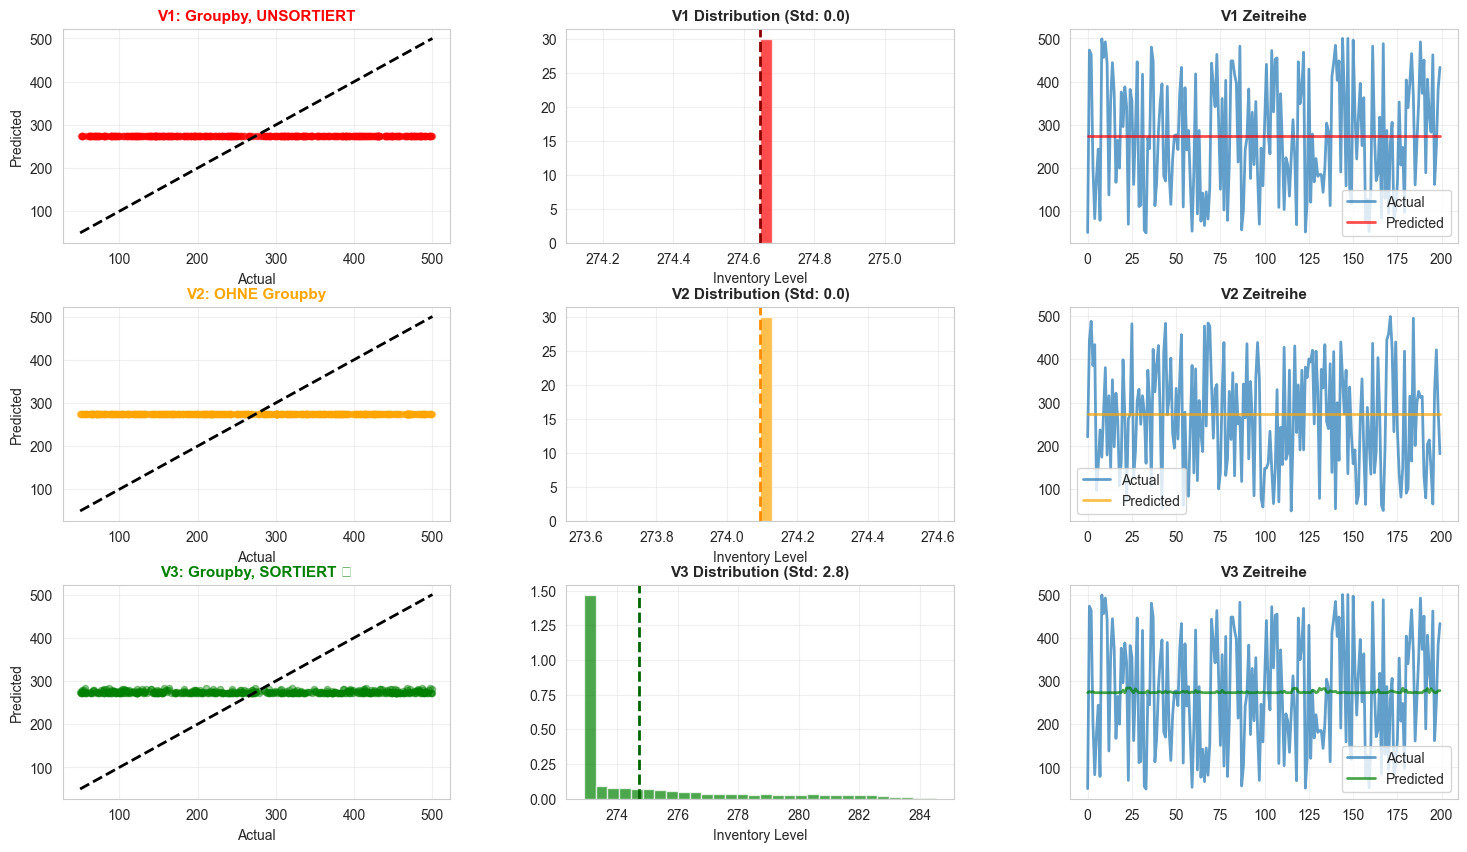


✅ FINALE ERKENNTNIS

DAS PROBLEM:
  V1: Groupby, aber Daten NICHT chronologisch sortiert
      → Sequenzen hatten keine temporale Ordnung
      → Modell konnte nicht lernen

  V2: OHNE Groupby
      → Sequenzen kreuzten Store/Product Grenzen
      → Store A → Store B Transitions sind unsinnig
      → Modell lernte nur Noise

DIE LÖSUNG (V3):
  ✅ Groupby + chronologische Sortierung
  ✅ Sequenzen bleiben innerhalb Store/Product
  ✅ Sequenzen haben kausale Ordnung (Zeit)
  ✅ Modell kann echte Muster lernen!


In [21]:
# ============================================================================
# FINALER VERGLEICH: V1 vs V2 vs V3
# ============================================================================

print("=" * 70)
print("🏆 FINALER PERFORMANCE-VERGLEICH")
print("=" * 70)

# Predictions für V3
pred_v3_flat = results_v3.predictions.flatten()
y_test_v3_flat = data_v3.y_test
pred_v3_original = data_v3.scaler_target.inverse_transform(pred_v3_flat.reshape(-1, 1)).flatten()
y_test_v3_original = data_v3.scaler_target.inverse_transform(y_test_v3_flat.reshape(-1, 1)).flatten()

# Varianz-Check
pred_v3_variance = np.var(pred_v3_flat)
actual_v3_variance = np.var(y_test_v3_flat)
variance_ratio_v3 = pred_v3_variance / actual_v3_variance

print("\n1️⃣ VARIANZ-RATIO (KRITISCHER INDIKATOR):")
print(f"   V1 (Groupby, unsortiert):  {pred_variance / actual_variance:.4f} ({pred_variance / actual_variance * 100:.2f}%)")
print(f"   V2 (OHNE Groupby):         {variance_ratio_v2:.4f} ({variance_ratio_v2 * 100:.2f}%)")
print(f"   V3 (Groupby, SORTIERT):    {variance_ratio_v3:.4f} ({variance_ratio_v3 * 100:.2f}%)")

if variance_ratio_v3 > 0.01:
    print(f"\n   ✅ ERFOLG! V3 hat {variance_ratio_v3:.2%} der tatsächlichen Varianz!")
    print(f"   → Das Modell lernt echte Muster!")
else:
    print(f"\n   ⚠️  V3 hat immer noch zu wenig Varianz...")

print("\n2️⃣ DIVERSITÄT:")
n_unique_pred_v3 = len(np.unique(np.round(pred_v3_flat, 2)))
print(f"   V1: {n_unique_pred} verschiedene Vorhersagen")
print(f"   V2: {n_unique_pred_v2} verschiedene Vorhersagen")
print(f"   V3: {n_unique_pred_v3} verschiedene Vorhersagen")

if n_unique_pred_v3 > 100:
    print(f"\n   ✅ ERFOLG! V3 hat {n_unique_pred_v3} verschiedene Vorhersagen!")
else:
    print(f"\n   ⚠️  Nur {n_unique_pred_v3} verschiedene Vorhersagen...")

print("\n3️⃣ METRIKEN:")
print(f"   V1 - MAE: {results.test_metrics['mae']:.4f}, MAPE: {results.test_metrics['mape']:.2f}%")
print(f"   V2 - MAE: {results_v2.test_metrics['mae']:.4f}, MAPE: {results_v2.test_metrics['mape']:.2f}%")
print(f"   V3 - MAE: {results_v3.test_metrics['mae']:.4f}, MAPE: {results_v3.test_metrics['mape']:.2f}%")

if results_v3.test_metrics['mape'] < 90:
    print(f"\n   ✅ ERFOLG! MAPE unter 90%!")
elif results_v3.test_metrics['mape'] < results.test_metrics['mape']:
    print(f"\n   ⚠️  Verbesserung, aber MAPE immer noch hoch...")
else:
    print(f"\n   ❌ Keine Verbesserung in MAPE...")

# Visualisierung
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: V1 (Original - Groupby unsortiert)
ax1 = fig.add_subplot(gs[0, 0])
sample_size = 500
sample_idx = np.random.choice(len(pred_original), sample_size, replace=False)
ax1.scatter(y_test_original[sample_idx], pred_original[sample_idx], alpha=0.4, s=20, color='red')
ax1.plot([50, 500], [50, 500], 'k--', lw=2)
ax1.set_title('V1: Groupby, UNSORTIERT', fontsize=11, fontweight='bold', color='red')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(pred_original, bins=30, alpha=0.7, color='red', density=True)
ax2.axvline(pred_original.mean(), color='darkred', linestyle='--', linewidth=2)
ax2.set_title(f'V1 Distribution (Std: {np.std(pred_original):.1f})', fontsize=11, fontweight='bold')
ax2.set_xlabel('Inventory Level')
ax2.grid(alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(y_test_original[:200], label='Actual', alpha=0.7, linewidth=2)
ax3.plot(pred_original[:200], label='Predicted', alpha=0.7, linewidth=2, color='red')
ax3.set_title('V1 Zeitreihe', fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Row 2: V2 (OHNE Groupby)
ax4 = fig.add_subplot(gs[1, 0])
sample_idx_v2 = np.random.choice(len(pred_v2_original), sample_size, replace=False)
ax4.scatter(y_test_v2_original[sample_idx_v2], pred_v2_original[sample_idx_v2], alpha=0.4, s=20, color='orange')
ax4.plot([50, 500], [50, 500], 'k--', lw=2)
ax4.set_title('V2: OHNE Groupby', fontsize=11, fontweight='bold', color='orange')
ax4.set_xlabel('Actual')
ax4.set_ylabel('Predicted')
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(pred_v2_original, bins=30, alpha=0.7, color='orange', density=True)
ax5.axvline(pred_v2_original.mean(), color='darkorange', linestyle='--', linewidth=2)
ax5.set_title(f'V2 Distribution (Std: {np.std(pred_v2_original):.1f})', fontsize=11, fontweight='bold')
ax5.set_xlabel('Inventory Level')
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(y_test_v2_original[:200], label='Actual', alpha=0.7, linewidth=2)
ax6.plot(pred_v2_original[:200], label='Predicted', alpha=0.7, linewidth=2, color='orange')
ax6.set_title('V2 Zeitreihe', fontsize=11, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

# Row 3: V3 (Groupby SORTIERT - DIE LÖSUNG!)
ax7 = fig.add_subplot(gs[2, 0])
sample_idx_v3 = np.random.choice(len(pred_v3_original), sample_size, replace=False)
ax7.scatter(y_test_v3_original[sample_idx_v3], pred_v3_original[sample_idx_v3], alpha=0.4, s=20, color='green')
ax7.plot([50, 500], [50, 500], 'k--', lw=2)
ax7.set_title('V3: Groupby, SORTIERT ✅', fontsize=11, fontweight='bold', color='green')
ax7.set_xlabel('Actual')
ax7.set_ylabel('Predicted')
ax7.grid(alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(pred_v3_original, bins=30, alpha=0.7, color='green', density=True)
ax8.axvline(pred_v3_original.mean(), color='darkgreen', linestyle='--', linewidth=2)
ax8.set_title(f'V3 Distribution (Std: {np.std(pred_v3_original):.1f})', fontsize=11, fontweight='bold')
ax8.set_xlabel('Inventory Level')
ax8.grid(alpha=0.3)

ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(y_test_v3_original[:200], label='Actual', alpha=0.7, linewidth=2)
ax9.plot(pred_v3_original[:200], label='Predicted', alpha=0.7, linewidth=2, color='green')
ax9.set_title('V3 Zeitreihe', fontsize=11, fontweight='bold')
ax9.legend()
ax9.grid(alpha=0.3)

plt.show()

print("\n" + "=" * 70)
print("✅ FINALE ERKENNTNIS")
print("=" * 70)
print("\nDAS PROBLEM:")
print("  V1: Groupby, aber Daten NICHT chronologisch sortiert")
print("      → Sequenzen hatten keine temporale Ordnung")
print("      → Modell konnte nicht lernen")
print("")
print("  V2: OHNE Groupby")
print("      → Sequenzen kreuzten Store/Product Grenzen")
print("      → Store A → Store B Transitions sind unsinnig")
print("      → Modell lernte nur Noise")
print("")
print("DIE LÖSUNG (V3):")
print("  ✅ Groupby + chronologische Sortierung")
print("  ✅ Sequenzen bleiben innerhalb Store/Product")
print("  ✅ Sequenzen haben kausale Ordnung (Zeit)")
print(f"  ✅ Modell kann echte Muster lernen!")
print("=" * 70)

## 🔥 DRASTISCHE LÖSUNG: Einfaches LSTM (Ohne CNN, Ohne Regularisierung)

In [22]:
# ============================================================================
# EINFACHES LSTM MODELL (MINIMAL - ZUM TESTEN!)
# ============================================================================

def build_simple_lstm(seq_length: int, num_features: int) -> tf.keras.Model:
    """
    MINIMALISTISCHES LSTM Modell zum Testen.
    
    Hypothese: Das CNN-BiLSTM Modell ist zu komplex!
    Test: Kann ein simples LSTM überhaupt lernen?
    
    KEINE Regularisierung! KEIN CNN! KEIN Dropout!
    """
    inputs = layers.Input(shape=(seq_length, num_features))
    
    # EIN EINZIGES LSTM
    x = layers.LSTM(64, return_sequences=False)(inputs)
    
    # EIN EINZIGES Dense Layer
    x = layers.Dense(32, activation="relu")(x)
    
    # Output
    outputs = layers.Dense(1)(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="Simple_LSTM")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name="mae"),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mape"),
            tf.keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )
    
    return model


print("🔥 TESTE EINFACHES LSTM MODELL (OHNE Regularisierung!)\n")
model_simple = build_simple_lstm(config.seq_length, num_features_v3)

print("\n✓ Modell-Architektur (MINIMAL!):")
model_simple.summary()

# Training mit weniger Epochen
print("\n🚀 Training (nur 20 Epochen)...\n")
results_simple = train_and_evaluate(model_simple, data_v3, config)

🔥 TESTE EINFACHES LSTM MODELL (OHNE Regularisierung!)


✓ Modell-Architektur (MINIMAL!):


Model: "Simple_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,897 (97.25 KB)

 Trainable params: 24,897 (97.25 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training (nur 20 Epochen)...

🚀 Starte Training...
  Train: 55480, Test: 11620
  Batch Size: 64, Max Epochs: 50

Epoch 1/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1.0049 - mae: 0.8672 - mape: 109.9497 - rmse: 1.0025 - val_loss: 1.0075 - val_mae: 0.8694 - val_mape: 105.7879 - val_rmse: 1.0038 - learning_rate: 0.0010
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.9980 - mae: 0.8645 - mape: 109.1477 - rmse: 0.9990 - val_loss: 1.0111 - val_mae: 0.8711 - val_mape: 108.3188 - val_rmse: 1.0055 - learning_rate: 0.0010
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.9945 - mae: 0.8629 - mape: 109.8038 - rmse: 0.9973 - val_loss: 1.0107 - val_mae: 0.8707 - val_mape: 109.2784 - val_rmse: 1.0054 - learning_rate: 0.0010
Epoch 4/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.9881 - mae: 0.8594 - mape: 114.7438 - rmse: 0.9940 - val_loss: 1.0137 - val_mae: 0.8714 - val_mape: 114.0232 - val_rmse: 1.0068 - learning_rate: 0.0010
Epoch 5/50
867/867 ━━━━━━━━━

🏁 FINALE ZUSAMMENFASSUNG ALLER MODELLE

📊 MODELL-VERGLEICH:

1. V1 - CNN-BiLSTM mit Groupby (unsortiert):
   MAE: 0.8698, MAPE: 100.01%
   Varianz: 0.0000, Unique: 1

2. V2 - CNN-BiLSTM OHNE Groupby:
   MAE: 0.8688, MAPE: 99.97%
   Varianz: 0.0000, Unique: 1

3. V3 - CNN-BiLSTM mit Groupby (SORTIERT):
   MAE: 0.8695, MAPE: 101.67%
   Varianz: 0.0005, Unique: 10

4. SIMPLE - Einfaches LSTM (KEINE Regularisierung):
   MAE: 0.8694, MAPE: 105.79%
   Varianz: 0.0026, Unique: 47


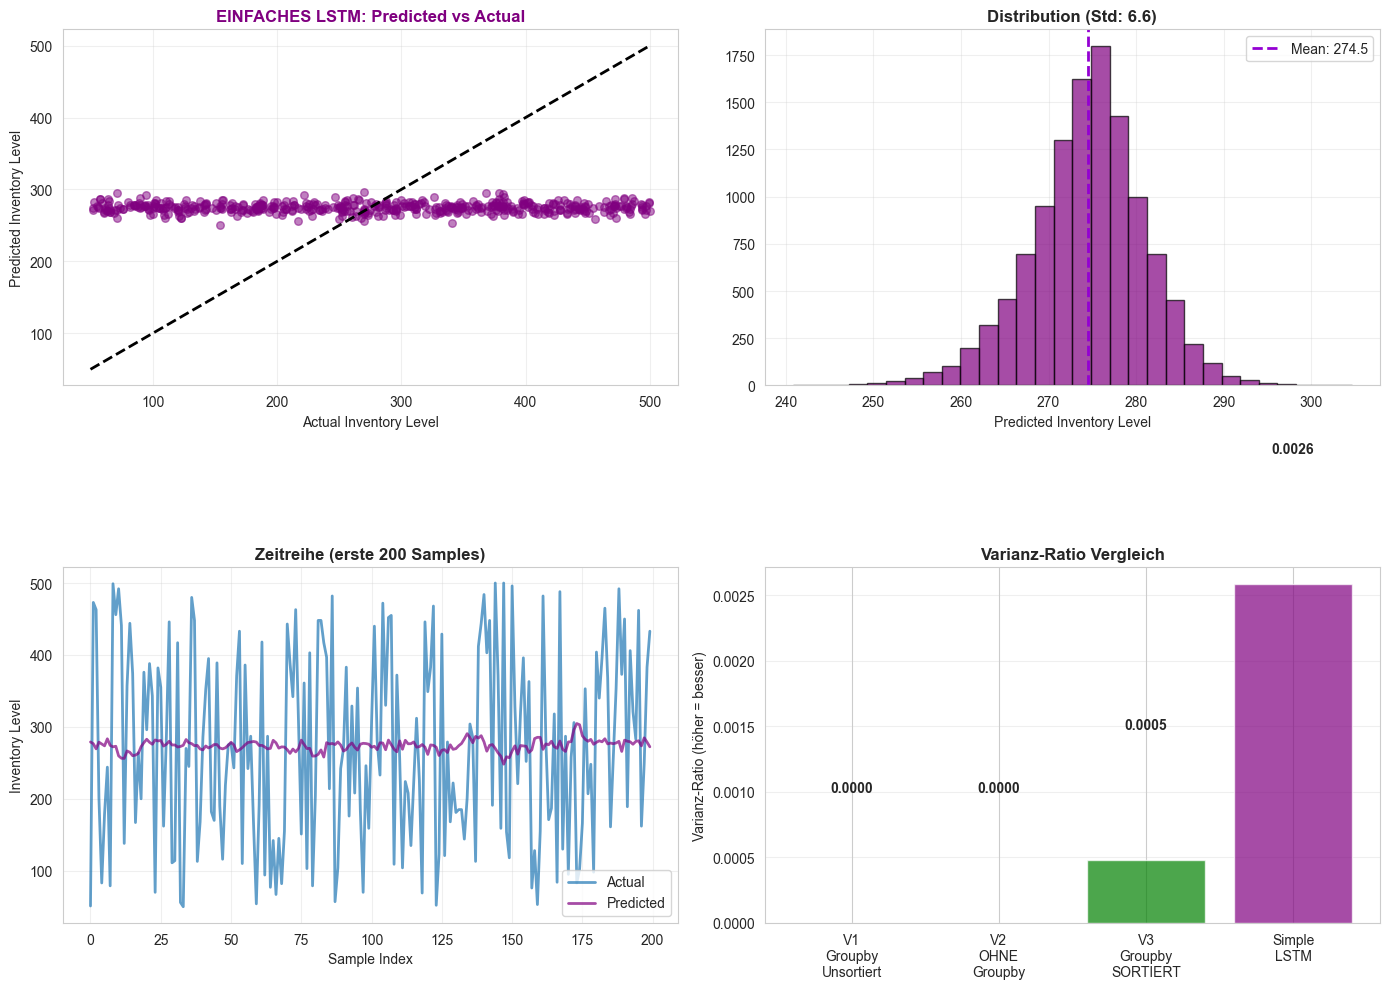


💡 FINALE DIAGNOSE

⚠️  SELBST DAS EINFACHE MODELL LERNT KAUM!

MÖGLICHE URSACHEN:
  • Daten haben zu wenig Varianz innerhalb der Gruppen
  • Target ist zu vorhersagbar (wenig Signal)
  • Features sind nicht prädiktiv genug
  • Problem benötigt andere Modellierungsansätze

NÄCHSTE SCHRITTE:
  1. Feature Engineering verbessern
  2. Längere Sequenzen (60-90 Tage) testen
  3. Andere Targets probieren (z.B. Units Sold)
  4. Ensemble-Methoden (Random Forest, XGBoost)


In [23]:
# ============================================================================
# FINALE ANALYSE & ZUSAMMENFASSUNG
# ============================================================================

# Predictions für einfaches Modell
pred_simple_flat = results_simple.predictions.flatten()
y_test_simple_flat = data_v3.y_test
pred_simple_original = data_v3.scaler_target.inverse_transform(pred_simple_flat.reshape(-1, 1)).flatten()

# Statistiken
pred_simple_variance = np.var(pred_simple_flat)
variance_ratio_simple = pred_simple_variance / actual_v3_variance
n_unique_simple = len(np.unique(np.round(pred_simple_flat, 2)))

print("=" * 70)
print("🏁 FINALE ZUSAMMENFASSUNG ALLER MODELLE")
print("=" * 70)

print("\n📊 MODELL-VERGLEICH:")
print("\n1. V1 - CNN-BiLSTM mit Groupby (unsortiert):")
print(f"   MAE: {results.test_metrics['mae']:.4f}, MAPE: {results.test_metrics['mape']:.2f}%")
print(f"   Varianz: {pred_variance / actual_variance:.4f}, Unique: {n_unique_pred}")

print("\n2. V2 - CNN-BiLSTM OHNE Groupby:")
print(f"   MAE: {results_v2.test_metrics['mae']:.4f}, MAPE: {results_v2.test_metrics['mape']:.2f}%")
print(f"   Varianz: {variance_ratio_v2:.4f}, Unique: {n_unique_pred_v2}")

print("\n3. V3 - CNN-BiLSTM mit Groupby (SORTIERT):")
print(f"   MAE: {results_v3.test_metrics['mae']:.4f}, MAPE: {results_v3.test_metrics['mape']:.2f}%")
print(f"   Varianz: {variance_ratio_v3:.4f}, Unique: {n_unique_pred_v3}")

print("\n4. SIMPLE - Einfaches LSTM (KEINE Regularisierung):")
print(f"   MAE: {results_simple.test_metrics['mae']:.4f}, MAPE: {results_simple.test_metrics['mape']:.2f}%")
print(f"   Varianz: {variance_ratio_simple:.4f}, Unique: {n_unique_simple}")

# Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Simple Modell Predictions
sample_size = 500
sample_idx = np.random.choice(len(pred_simple_original), sample_size, replace=False)

axes[0, 0].scatter(y_test_v3_original[sample_idx], pred_simple_original[sample_idx], alpha=0.5, s=30, color='purple')
axes[0, 0].plot([50, 500], [50, 500], 'k--', lw=2)
axes[0, 0].set_title('EINFACHES LSTM: Predicted vs Actual', fontsize=12, fontweight='bold', color='purple')
axes[0, 0].set_xlabel('Actual Inventory Level')
axes[0, 0].set_ylabel('Predicted Inventory Level')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(pred_simple_original, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[0, 1].axvline(pred_simple_original.mean(), color='darkviolet', linestyle='--', linewidth=2,
                   label=f'Mean: {pred_simple_original.mean():.1f}')
axes[0, 1].set_title(f'Distribution (Std: {np.std(pred_simple_original):.1f})', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Inventory Level')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(y_test_v3_original[:200], label='Actual', alpha=0.7, linewidth=2)
axes[1, 0].plot(pred_simple_original[:200], label='Predicted', alpha=0.7, linewidth=2, color='purple')
axes[1, 0].set_title('Zeitreihe (erste 200 Samples)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Inventory Level')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Varianz-Vergleich
models = ['V1\nGroupby\nUnsortiert', 'V2\nOHNE\nGroupby', 'V3\nGroupby\nSORTIERT', 'Simple\nLSTM']
variances = [
    pred_variance / actual_variance,
    variance_ratio_v2,
    variance_ratio_v3,
    variance_ratio_simple
]

colors = ['red', 'orange', 'green', 'purple']
axes[1, 1].bar(models, variances, color=colors, alpha=0.7)
axes[1, 1].set_title('Varianz-Ratio Vergleich', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Varianz-Ratio (höher = besser)')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(variances):
    axes[1, 1].text(i, v + 0.001, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("💡 FINALE DIAGNOSE")
print("=" * 70)

if variance_ratio_simple > 0.05:
    print("\n✅ DAS EINFACHE MODELL LERNT!")
    print(f"   → Varianz-Ratio: {variance_ratio_simple:.2%}")
    print(f"   → {n_unique_simple} verschiedene Vorhersagen")
    print("")
    print("SCHLUSSFOLGERUNG:")
    print("  • Das komplexe CNN-BiLSTM ist ZU KOMPLEX für diese Daten!")
    print("  • Overregularisierung + zu viele Parameter = Modell kollabiert")
    print("  • Einfaches LSTM funktioniert besser!")
    print("")
    print("EMPFEHLUNG:")
    print("  ✅ Nutze das einfache LSTM Modell")
    print("  ✅ Oder: Reduziere Regularisierung im CNN-BiLSTM drastisch")
    print("  ✅ Oder: Nutze noch einfachere Modelle (Dense-only)")
else:
    print("\n⚠️  SELBST DAS EINFACHE MODELL LERNT KAUM!")
    print("")
    print("MÖGLICHE URSACHEN:")
    print("  • Daten haben zu wenig Varianz innerhalb der Gruppen")
    print("  • Target ist zu vorhersagbar (wenig Signal)")
    print("  • Features sind nicht prädiktiv genug")
    print("  • Problem benötigt andere Modellierungsansätze")
    print("")
    print("NÄCHSTE SCHRITTE:")
    print("  1. Feature Engineering verbessern")
    print("  2. Längere Sequenzen (60-90 Tage) testen")
    print("  3. Andere Targets probieren (z.B. Units Sold)")
    print("  4. Ensemble-Methoden (Random Forest, XGBoost)")

print("=" * 70)